In [1]:
#Loading the data
import pandas as pd
df=pd.read_csv('LSTM-Multivariate_pollution.csv',parse_dates=['date']).rename(columns={"date":"Date"})
#Grouping the data by day
df=df.groupby([df['Date'].dt.date])[['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd','snow', 'rain']].mean()
df.head()

,pollution,dew,temp,press,wnd_spd,snow,rain
Date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 2010-01-02 to 2014-12-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dew        1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1+ KB


In [3]:
#First, we´ll only use the pollution target
df_pollution=pd.DataFrame(df["pollution"]).rename(columns={"pollution":"Pollution"})
df_pollution.head()

,Pollution
Date,
2010-01-02,145.958333
2010-01-03,78.833333
2010-01-04,31.333333
2010-01-05,42.458333
2010-01-06,56.416667


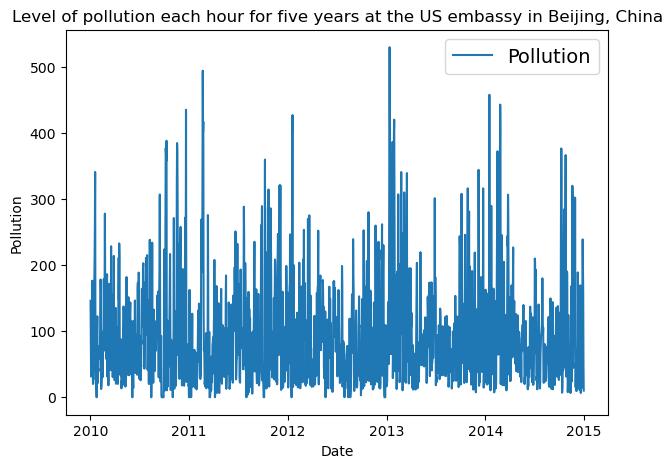

In [4]:
import matplotlib.pyplot as plt
df_pollution.plot(figsize=(7,5));
plt.ylabel("Pollution");
plt.title("Level of pollution each hour for five years at the US embassy in Beijing, China",fontsize=12);
plt.legend(fontsize=14);

## Format data part 1: Create train and test sets of our time series data

In [5]:
#Get pollution date array
timesteps=df_pollution.index.to_numpy()
pollution=df_pollution["Pollution"].to_numpy()

timesteps[:5],pollution[:5]

(array([datetime.date(2010, 1, 2), datetime.date(2010, 1, 3),
        datetime.date(2010, 1, 4), datetime.date(2010, 1, 5),
        datetime.date(2010, 1, 6)], dtype=object),
 array([145.95833333,  78.83333333,  31.33333333,  42.45833333,
         56.41666667]))

In [6]:
#Create train and test splits for time series data
split_size=int(0.8*len(pollution)) # 80% train, 20% test

#Create train data splits (everything before the split)
X_train,y_train=timesteps[:split_size] , pollution[:split_size]

#Create test data splits (everything beyond the split)
X_test,y_test=timesteps[split_size:],pollution[split_size:]

len(X_train) ,len(X_test) , len(y_train) ,len(y_test)

(1460, 365, 1460, 365)

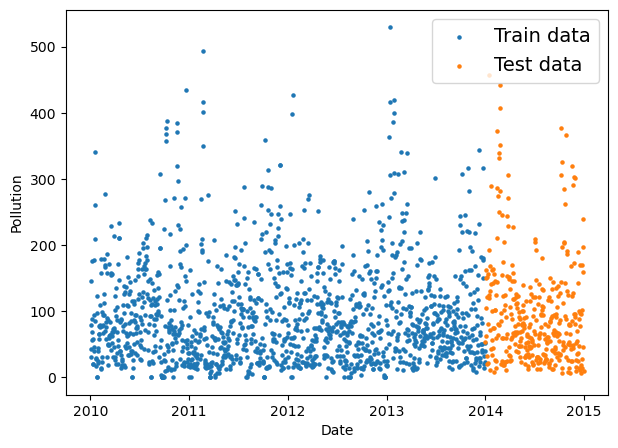

In [7]:
#Ploting the splits created
plt.figure(figsize=(7,5));
plt.scatter(X_train,y_train,s=5,label='Train data');
plt.scatter(X_test,y_test,s=5,label='Test data');
plt.xlabel("Date");
plt.ylabel("Pollution");
plt.legend(fontsize=14);
plt.show();

## Creating a plotting function

In [8]:
#Create a function to plot time series data
def plot_time_series(timesteps1,values1,timesteps2,values2,format1=".",format2="-",start=0,end=None ,label1=None,label2=None):
  #Plot the series
  plt.figure(figsize=(10,7));
  plt.plot(timesteps1[start:end],values1[start:end],format1,label=label1);
  plt.plot(timesteps2[start:end],values2[start:end],format2,label=label2);
  plt.xlabel("Time");
  plt.ylabel("Pollution");
  if label1:
    plt.legend(fontsize=12); #make label bigger
  plt.grid(True);

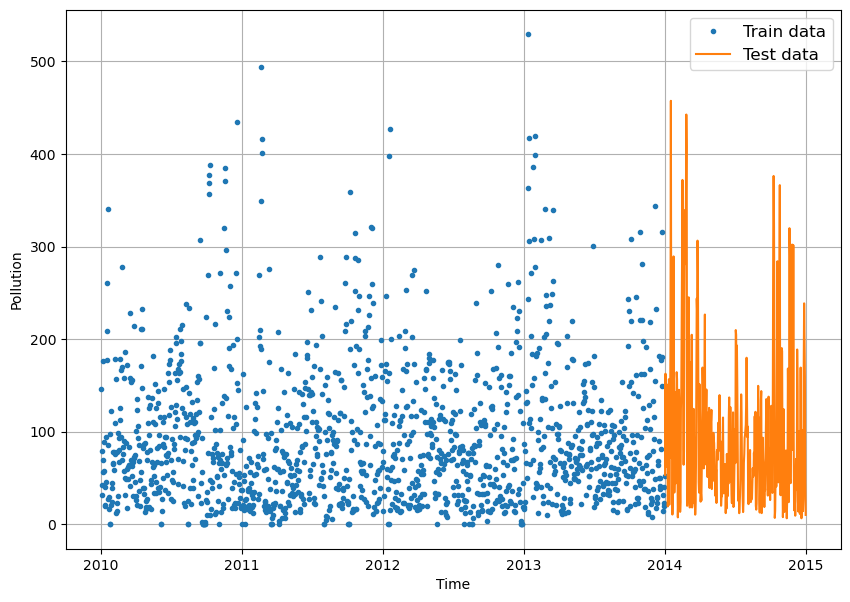

In [9]:
#Test our plotting function
plot_time_series(timesteps1=X_train,values1=y_train,timesteps2=X_test,values2=y_test,label1='Train data',label2="Test data")

# Modelling experiments

In [10]:
#MASE Implementation
def mean_absolute_scaled_error(y_true,y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae=tf.reduce_mean(tf.abs(y_true-y_pred))

  #Find MAE of naive forecast (no seasonality)
  mae_naive_no_season=tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) #our seasonality is 1 day (hence, the shift of 1)

  return mae/mae_naive_no_season

In [11]:
# Create a function to take in model predictions and truth values and return and evaluation metrics

def evaluate_preds(y_true,y_pred):
  #Make sure float32 datatype (for metric calculation)
  y_true=tf.cast(y_true,dtype=tf.float32)
  y_pred=tf.cast(y_pred,dtype=tf.float32)

  #Calculate various evaluation metrics
  mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse=tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse=tf.sqrt(mse)
  mape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase=mean_absolute_scaled_error(y_true,y_pred)
  ## For all of above metrics, a lower value is better

  return {'mae':mae.numpy(),
          'mse':mse.numpy(),
          'rmse':rmse.numpy(),
          'mape':mape.numpy(),
          'mase':mase.numpy()}

## Format Data Part 2 : Windowing our dataset

In [12]:
#Let´s set up variables for window and horizon size
HORIZON=1 #predict the level of pollution the next day
WINDOW_SIZE=7 #Use the past week of pollution data to make the prediction

In [13]:
#Create function to label windowed data
def get_labelled_windows(x,horizon=HORIZON):
  """
  Creates labels for windowed dataset
  E.g if horizon=1
  Input : [0,1,2,3,4,5,6,7] -> Output : ([0,1,2,3,4,5,6],[7])
  """
  return x[:,:-horizon] , x[:,-horizon:]

In [14]:
#Create function to view NumPy arrays as windows
import numpy as np
def make_windows(x,window_size=WINDOW_SIZE,horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of windows_size
  with horizon size labels
  """
  #1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step=np.expand_dims(np.arange(window_size+horizon),axis=0)

  #2. Create a 2D array of multiple steps (minus 1 to account for 0 indexing)
  window_indexes=window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)) ,axis=0 ).T #Create a 2D array of windows of size window_size

  # print(f"Window indexes:\n {window_indexes , window_indexes.shape}")

  #3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array=x[window_indexes]
  # print(windowed_array)

  #4. Get the labelled windows
  windows,labels=get_labelled_windows(windowed_array,horizon=horizon)

  return windows,labels

In [15]:
full_windows,full_labels=make_windows(pollution,window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows),len(full_labels)

(1818, 1818)

## Turning windows into training and test sets

In [16]:
#Make the train/test splits
def make_train_test_splits(windows,labels,test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size=int(len(windows)*(1-test_split)) #this will default to 80% train / 20% test
  train_windows=windows[:split_size]
  train_labels=labels[:split_size]
  test_windows=windows[split_size:]
  test_labels=labels[split_size:]
  return train_windows,test_windows,train_labels,test_labels

In [17]:
#Create train and test windows
train_windows,test_windows,train_labels,test_labels=make_train_test_splits(full_windows,full_labels)
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(1454, 364, 1454, 364)

# Univariate Time Series Models

## Make a modelling checkpoint callback

We want to compare each of our model´s best performances against the oher model´s best performance

In [18]:
import os

#Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name,save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                            monitor='val_loss',
                                            verbose=0, #only output a limited amount of text
                                            save_best_only=True)

## Model 1: Dense Model (window=7,horizon=1)

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

#Set random seed for as reproducible results as posible

#1. Construct model
model_1=tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name='model_1_dense') #name our model so we can save it


#2. Compile
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

#3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
12/12 [==============================] - 4s 209ms/step - loss: 61.0616 - mae: 61.0616 - mse: 7247.6426 - val_loss: 57.4690 - val_mae: 57.4690 - val_mse: 6288.1401
Epoch 2/100
12/12 [==============================] - 2s 152ms/step - loss: 55.2141 - mae: 55.2141 - mse: 5504.1733 - val_loss: 53.1283 - val_mae: 53.1283 - val_mse: 5393.1270
Epoch 3/100
12/12 [==============================] - 2s 153ms/step - loss: 50.9055 - mae: 50.9055 - mse: 4888.2285 - val_loss: 50.8642 - val_mae: 50.8642 - val_mse: 5070.8774
Epoch 4/100
12/12 [==============================] - 2s 164ms/step - loss: 48.9501 - mae: 48.9501 - mse: 4511.8262 - val_loss: 49.0900 - val_mae: 49.0900 - val_mse: 4731.9004
Epoch 5/100
12/12 [==============================] - 2s 153ms/step - loss: 48.2104 - mae: 48.2104 - mse: 4336.5059 - val_loss: 48.5509 - val_mae: 48.5509 - val_mse: 4664.9341
Epoch 6/100
12/12 [==============================] - 2s 168ms/step - loss: 47.8135 - mae: 47.8135 - mse: 4250.7168 - val_loss

12/12 [==============================] - 2s 164ms/step - loss: 46.3704 - mae: 46.3704 - mse: 4067.3130 - val_loss: 46.6700 - val_mae: 46.6700 - val_mse: 4344.8579
Epoch 31/100
12/12 [==============================] - 0s 9ms/step - loss: 46.3609 - mae: 46.3609 - mse: 4070.4131 - val_loss: 46.9648 - val_mae: 46.9648 - val_mse: 4379.7715
Epoch 32/100
12/12 [==============================] - 1s 135ms/step - loss: 46.2546 - mae: 46.2546 - mse: 4055.8840 - val_loss: 46.6331 - val_mae: 46.6331 - val_mse: 4331.8594
Epoch 33/100
12/12 [==============================] - 0s 9ms/step - loss: 46.2304 - mae: 46.2304 - mse: 4061.3132 - val_loss: 46.7114 - val_mae: 46.7114 - val_mse: 4353.4902
Epoch 34/100
12/12 [==============================] - 0s 8ms/step - loss: 46.2951 - mae: 46.2951 - mse: 4054.5244 - val_loss: 46.6610 - val_mae: 46.6610 - val_mse: 4338.9600
Epoch 35/100
12/12 [==============================] - 0s 8ms/step - loss: 46.1492 - mae: 46.1492 - mse: 4045.9453 - val_loss: 46.7794 - val

12/12 [==============================] - 1s 122ms/step - loss: 45.4291 - mae: 45.4291 - mse: 3962.1365 - val_loss: 46.1017 - val_mae: 46.1017 - val_mse: 4247.5928
Epoch 71/100
12/12 [==============================] - 0s 9ms/step - loss: 45.1939 - mae: 45.1939 - mse: 3945.2480 - val_loss: 46.1893 - val_mae: 46.1893 - val_mse: 4250.0444
Epoch 72/100
12/12 [==============================] - 0s 7ms/step - loss: 45.2826 - mae: 45.2826 - mse: 3944.3206 - val_loss: 46.2556 - val_mae: 46.2556 - val_mse: 4257.0840
Epoch 73/100
12/12 [==============================] - 1s 133ms/step - loss: 45.3243 - mae: 45.3243 - mse: 3952.8799 - val_loss: 46.0626 - val_mae: 46.0626 - val_mse: 4237.3276
Epoch 74/100
12/12 [==============================] - 0s 7ms/step - loss: 45.1266 - mae: 45.1266 - mse: 3935.0681 - val_loss: 46.3826 - val_mae: 46.3826 - val_mse: 4280.7207
Epoch 75/100
12/12 [==============================] - 0s 7ms/step - loss: 45.1779 - mae: 45.1779 - mse: 3927.7451 - val_loss: 46.3212 - val

In [20]:
#Evaluate model on test data
model_1.evaluate(test_windows,test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 46.0211 - mae: 46.0211 - mse: 4218.5303


[46.02106475830078, 46.02106475830078, 4218.5302734375]

In [21]:
#Load in saves best performing model_1 and evaluate it on test data
model_1=tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows,test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 46.0014 - mae: 46.0014 - mse: 4210.6738


[46.00142288208008, 46.00142288208008, 4210.673828125]

## Making forecasts with a model (on the test dataset)

In [22]:
def make_preds(model,input_data):
  """
  Uses model to make predictions input_data
  """
  forecast=model.predict(input_data,verbose=0)
  return tf.squeeze(forecast)  #return 1D array of predictions

In [23]:
#Make predictions using model_1 on the test dataset and view results
model_1_preds=make_preds(model_1,test_windows)
len(model_1_preds) , model_1_preds[:2]

(364,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 36.167133, 133.88997 ], dtype=float32)>)

In [24]:
#Evaluate preds
model_1_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_1_preds)

model_1_results

{'mae': 46.001427,
 'mse': 4210.6743,
 'rmse': 64.88971,
 'mape': 90.32863,
 'mase': 0.883243}

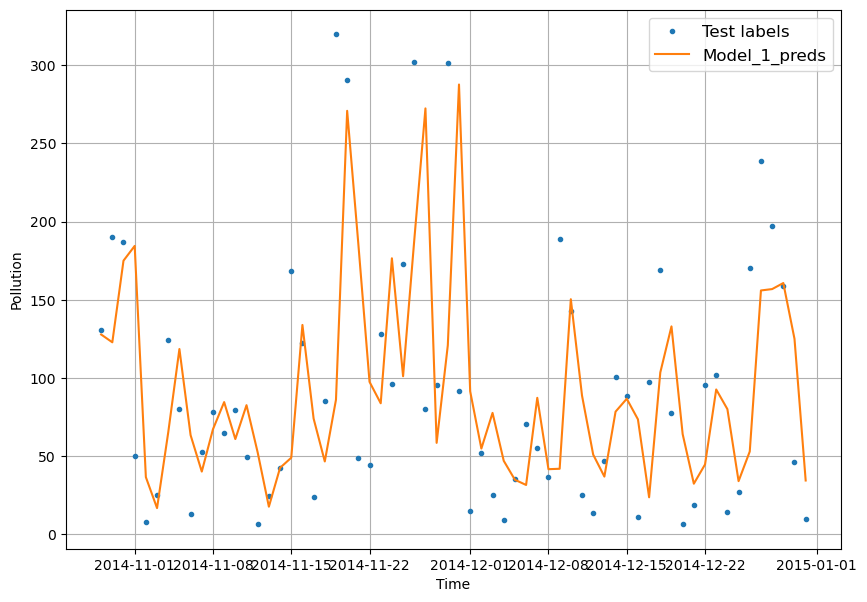

In [25]:
#Let´s plot our model 1 predictions
offset=300
#Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps1=X_test[-len(test_windows):],values1=test_labels[:,0],timesteps2=X_test[-len(test_windows):],values2=model_1_preds,format1=".",format2='-',start=offset,end=None ,label1="Test labels",label2='Model_1_preds');
plt.show();

## Model 2: Dense (window=30, horizon=1)

In [26]:
HORIZON=1 #Predict one step at a time 
WINDOW_SIZE=30 #Use 30 past days timesteps in past

In [27]:
#Make window data with appropriate horizon
full_windows,full_labels=make_windows(pollution,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(1795, 1795)

In [28]:
#Make train and testing windows
train_windows,test_windows,train_labels,test_labels=make_train_test_splits(full_windows,full_labels,test_split=0.2)

len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(1436, 359, 1436, 359)

In [29]:
import tensorflow as tf
from tensorflow.keras import layers

#Set random seed for as reproducible results as posible

#1. Construct model
model_2=tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name='model_2_dense') #name our model so we can save it


#2. Compile
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

#3. Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
12/12 [==============================] - 3s 165ms/step - loss: 68.9916 - mae: 68.9916 - mse: 8687.6025 - val_loss: 58.7748 - val_mae: 58.7748 - val_mse: 7572.9570
Epoch 2/100
12/12 [==============================] - 1s 120ms/step - loss: 58.9219 - mae: 58.9219 - mse: 6963.1558 - val_loss: 54.3701 - val_mae: 54.3700 - val_mse: 6191.6182
Epoch 3/100
12/12 [==============================] - 1s 136ms/step - loss: 53.8418 - mae: 53.8418 - mse: 5329.2715 - val_loss: 52.7271 - val_mae: 52.7271 - val_mse: 5796.2520
Epoch 4/100
12/12 [==============================] - 1s 121ms/step - loss: 51.0322 - mae: 51.0322 - mse: 4964.6973 - val_loss: 51.2285 - val_mae: 51.2285 - val_mse: 5146.8286
Epoch 5/100
12/12 [==============================] - 2s 136ms/step - loss: 49.1136 - mae: 49.1136 - mse: 4543.1982 - val_loss: 50.5824 - val_mae: 50.5824 - val_mse: 4939.8740
Epoch 6/100
12/12 [==============================] - 1s 121ms/step - loss: 47.9891 - mae: 47.9891 - mse: 4302.4468 - val_loss

12/12 [==============================] - 0s 7ms/step - loss: 38.8377 - mae: 38.8377 - mse: 3223.9795 - val_loss: 48.9862 - val_mae: 48.9862 - val_mse: 4761.8516
Epoch 39/100
12/12 [==============================] - 0s 7ms/step - loss: 38.6956 - mae: 38.6956 - mse: 3197.1021 - val_loss: 49.3209 - val_mae: 49.3209 - val_mse: 4793.1509
Epoch 40/100
12/12 [==============================] - 0s 7ms/step - loss: 38.7640 - mae: 38.7640 - mse: 3216.5269 - val_loss: 48.9289 - val_mae: 48.9289 - val_mse: 4686.6724
Epoch 41/100
12/12 [==============================] - 0s 7ms/step - loss: 38.5698 - mae: 38.5698 - mse: 3164.7122 - val_loss: 49.0228 - val_mae: 49.0228 - val_mse: 4688.0962
Epoch 42/100
12/12 [==============================] - 0s 6ms/step - loss: 38.2123 - mae: 38.2123 - mse: 3157.4331 - val_loss: 49.4343 - val_mae: 49.4343 - val_mse: 4823.8418
Epoch 43/100
12/12 [==============================] - 0s 7ms/step - loss: 38.1798 - mae: 38.1798 - mse: 3141.4207 - val_loss: 49.2330 - val_mae

12/12 [==============================] - 0s 7ms/step - loss: 31.9848 - mae: 31.9848 - mse: 2452.0623 - val_loss: 52.0381 - val_mae: 52.0381 - val_mse: 5235.0840
Epoch 86/100
12/12 [==============================] - 0s 7ms/step - loss: 31.9906 - mae: 31.9906 - mse: 2453.2646 - val_loss: 51.9760 - val_mae: 51.9760 - val_mse: 5246.6963
Epoch 87/100
12/12 [==============================] - 0s 7ms/step - loss: 31.8305 - mae: 31.8305 - mse: 2430.6558 - val_loss: 52.2526 - val_mae: 52.2526 - val_mse: 5222.5625
Epoch 88/100
12/12 [==============================] - 0s 6ms/step - loss: 31.7285 - mae: 31.7285 - mse: 2429.4548 - val_loss: 51.7092 - val_mae: 51.7092 - val_mse: 5182.3330
Epoch 89/100
12/12 [==============================] - 0s 7ms/step - loss: 31.7341 - mae: 31.7341 - mse: 2413.6807 - val_loss: 52.5502 - val_mae: 52.5502 - val_mse: 5315.7515
Epoch 90/100
12/12 [==============================] - 0s 7ms/step - loss: 31.7758 - mae: 31.7758 - mse: 2424.1423 - val_loss: 52.7269 - val_mae

In [30]:
#Evaluate model on test data
model_2.evaluate(test_windows,test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 52.7248 - mae: 52.7248 - mse: 5352.6050


[52.72480010986328, 52.72480010986328, 5352.60498046875]

In [31]:
#Load in saves best performing model_2 and evaluate it on test data
model_2=tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows,test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 48.1425 - mae: 48.1425 - mse: 4640.5576


[48.142452239990234, 48.142452239990234, 4640.5576171875]

In [32]:
#Make predictions using model_2 on the test dataset and view results
model_2_preds=make_preds(model_2,test_windows)
len(model_2_preds) , model_2_preds[:2]

(359,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([153.09335 ,  89.847404], dtype=float32)>)

In [33]:
#Evaluate preds
model_2_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_2_preds)

model_2_results

{'mae': 48.142452,
 'mse': 4640.5576,
 'rmse': 68.121635,
 'mape': 95.001854,
 'mase': 0.92690974}

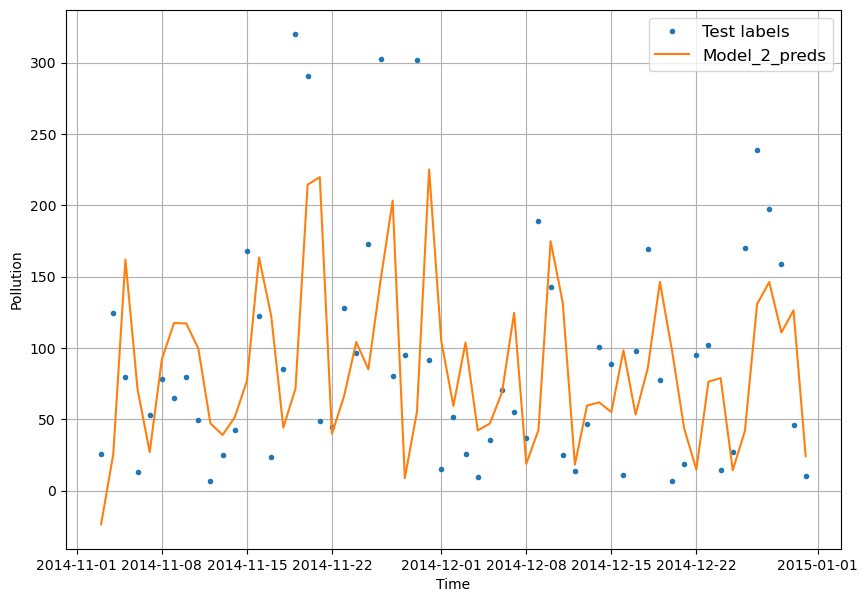

In [34]:
#Let´s plot our model 2 predictions
offset=300
#Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps1=X_test[-len(test_windows):],values1=test_labels[:,0],timesteps2=X_test[-len(test_windows):],values2=model_2_preds,format1=".",format2='-',start=offset,end=None ,label1="Test labels",label2='Model_2_preds');
plt.show();

## Model 3: Dense Model (window=30,horizon=7)

In [35]:
HORIZON=7
WINDOW_SIZE=30

#Make window data with appropriate horizon
full_windows,full_labels=make_windows(pollution,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(1789, 1789)

In [36]:
#Make train and testing windows
train_windows,test_windows,train_labels,test_labels=make_train_test_splits(full_windows,full_labels,test_split=0.2)

len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(1431, 358, 1431, 358)

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

#Set random seed for as reproducible results as posible

#1. Construct model
model_3=tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name='model_3_dense') #name our model so we can save it


#2. Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

#3. Fit the model
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
12/12 [==============================] - 2s 147ms/step - loss: 72.8706 - mae: 72.8706 - mse: 9913.8730 - val_loss: 65.2769 - val_mae: 65.2769 - val_mse: 8113.6318
Epoch 2/100
12/12 [==============================] - 2s 139ms/step - loss: 63.8046 - mae: 63.8046 - mse: 7322.0713 - val_loss: 61.3257 - val_mae: 61.3257 - val_mse: 7601.9546
Epoch 3/100
12/12 [==============================] - 1s 123ms/step - loss: 60.3205 - mae: 60.3205 - mse: 6913.9673 - val_loss: 59.9600 - val_mae: 59.9600 - val_mse: 7368.9233
Epoch 4/100
12/12 [==============================] - 2s 139ms/step - loss: 59.0785 - mae: 59.0785 - mse: 6629.4219 - val_loss: 58.8647 - val_mae: 58.8647 - val_mse: 7069.7212
Epoch 5/100
12/12 [==============================] - 1s 125ms/step - loss: 58.0885 - mae: 58.0885 - mse: 6535.5381 - val_loss: 58.3549 - val_mae: 58.3549 - val_mse: 7033.4497
Epoch 6/100
12/12 [==============================] - 2s 141ms/step - loss: 57.4478 - mae: 57.4478 - mse: 6352.8691 - val_loss

12/12 [==============================] - 0s 9ms/step - loss: 52.7839 - mae: 52.7839 - mse: 5757.7915 - val_loss: 56.9754 - val_mae: 56.9754 - val_mse: 6650.1250
Epoch 31/100
12/12 [==============================] - 0s 7ms/step - loss: 52.7418 - mae: 52.7418 - mse: 5711.7319 - val_loss: 56.9881 - val_mae: 56.9881 - val_mse: 6824.8604
Epoch 32/100
12/12 [==============================] - 0s 8ms/step - loss: 52.6514 - mae: 52.6514 - mse: 5682.6230 - val_loss: 56.9548 - val_mae: 56.9548 - val_mse: 6759.6797
Epoch 33/100
12/12 [==============================] - 0s 7ms/step - loss: 52.5681 - mae: 52.5681 - mse: 5761.4653 - val_loss: 57.1344 - val_mae: 57.1344 - val_mse: 6708.9136
Epoch 34/100
12/12 [==============================] - 0s 7ms/step - loss: 52.6411 - mae: 52.6411 - mse: 5704.6265 - val_loss: 56.9475 - val_mae: 56.9475 - val_mse: 6772.8540
Epoch 35/100
12/12 [==============================] - 0s 7ms/step - loss: 52.3871 - mae: 52.3871 - mse: 5677.7993 - val_loss: 57.0218 - val_mae

12/12 [==============================] - 0s 7ms/step - loss: 48.9690 - mae: 48.9690 - mse: 5149.3911 - val_loss: 58.2911 - val_mae: 58.2911 - val_mse: 6991.8833
Epoch 78/100
12/12 [==============================] - 0s 7ms/step - loss: 48.7646 - mae: 48.7646 - mse: 5108.2588 - val_loss: 58.3958 - val_mae: 58.3958 - val_mse: 7040.3184
Epoch 79/100
12/12 [==============================] - 0s 7ms/step - loss: 48.8548 - mae: 48.8548 - mse: 5097.1094 - val_loss: 58.5165 - val_mae: 58.5165 - val_mse: 7171.4702
Epoch 80/100
12/12 [==============================] - 0s 7ms/step - loss: 48.7646 - mae: 48.7646 - mse: 5093.9121 - val_loss: 58.3733 - val_mae: 58.3733 - val_mse: 7066.5630
Epoch 81/100
12/12 [==============================] - 0s 7ms/step - loss: 48.7704 - mae: 48.7704 - mse: 5069.5044 - val_loss: 58.3026 - val_mae: 58.3026 - val_mse: 7046.6245
Epoch 82/100
12/12 [==============================] - 0s 7ms/step - loss: 48.5328 - mae: 48.5328 - mse: 5051.8516 - val_loss: 58.6188 - val_mae

In [38]:
#Evaluate model on test data
model_3.evaluate(test_windows,test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 59.1568 - mae: 59.1568 - mse: 7087.1206


[59.15683364868164, 59.15683364868164, 7087.12060546875]

In [39]:
#Load in saves best performing model_3 and evaluate it on test data
model_3=tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows,test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 56.8709 - mae: 56.8709 - mse: 6855.0308


[56.87092971801758, 56.87092971801758, 6855.03076171875]

In [40]:
#Make predictions using model_3 on the test dataset and view results
model_3_preds=make_preds(model_3,test_windows)
len(model_3_preds) , model_3_preds[:2]

(358,
 <tf.Tensor: shape=(2, 7), dtype=float32, numpy=
 array([[ 55.980976,  50.8816  ,  47.794468,  40.668373,  64.47845 ,
          60.967983,  68.99762 ],
        [142.5817  ,  93.96177 ,  30.440168,  73.51225 ,  67.55495 ,
          61.538452,  82.450874]], dtype=float32)>)

## Make our evaluation function work for larger horizons

In [41]:
# Create a function to take in model predictions and truth values and return evaluation metrics

def evaluate_preds(y_true,y_pred):
  #Make sure float32 datatype (for metric calculation)
  y_true=tf.cast(y_true,dtype=tf.float32)
  y_pred=tf.cast(y_pred,dtype=tf.float32)

  #Calculate various evaluation metrics
  mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse=tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse=tf.sqrt(mse)
  mape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase=mean_absolute_scaled_error(y_true,y_pred)

  #Account for different sized metrics (for longer horizons, we want to reduce
  #metrics to a single value)
  if mae.ndim>0:
    mae=tf.reduce_mean(mae)
    mse=tf.reduce_mean(mse)
    rmse=tf.reduce_mean(rmse)
    mape=tf.reduce_mean(mape)
    mase=tf.reduce_mean(mase)

  return {'mae':mae.numpy(),
          'mse':mse.numpy(),
          'rmse':rmse.numpy(),
          'mape':mape.numpy(),
          'mase':mase.numpy()}

In [42]:
#Evaluate preds
model_3_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_3_preds)

model_3_results

{'mae': 56.87093,
 'mse': 6855.031,
 'rmse': 69.807526,
 'mape': 103.38705,
 'mase': 1.097714}

In [43]:
model_3_preds.shape

TensorShape([358, 7])

In [44]:
tf.squeeze(test_labels).shape

TensorShape([358, 7])

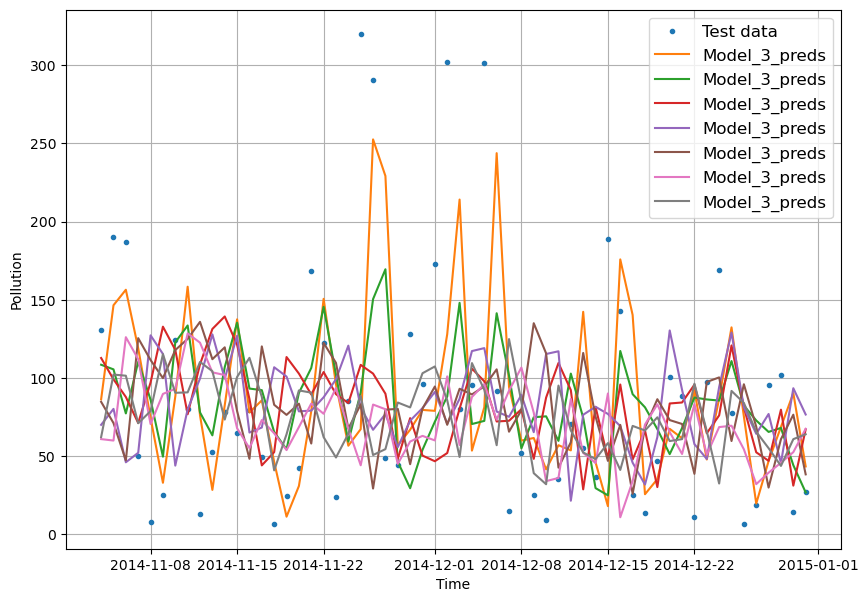

In [45]:
#Let´s plot our model 3 predictions
offset=300
#Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps1=X_test[-len(test_windows):],values1=test_labels[:,0],timesteps2=X_test[-len(test_windows):],values2=model_3_preds,format1=".",format2='-',start=offset,end=None ,label1="Test data",label2='Model_3_preds');
plt.show();

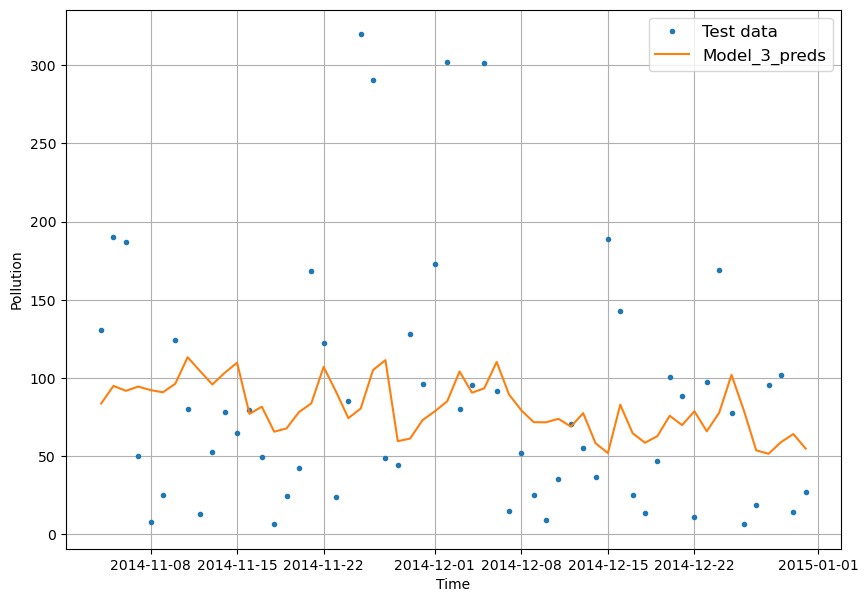

In [46]:
#Let´s plot our model 3 predictions
offset=300
#Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps1=X_test[-len(test_windows):],values1=test_labels[:,0],timesteps2=X_test[-len(test_windows):],values2=tf.reduce_mean(model_3_preds,axis=1),format1=".",format2='-',start=offset,end=None ,label1="Test data",label2='Model_3_preds');
plt.show();

## Model 4: Conv1D

In [47]:
HORIZON=1  #predict next day level of pollution
WINDOW_SIZE=7 #use previous week data

#Create windowed data
full_windows,full_labels=make_windows(pollution,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(1818, 1818)

In [48]:
#Create train/test sets
train_windows,test_windows,train_labels,test_labels=make_train_test_splits(full_windows,full_labels,test_split=0.2)
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(1454, 364, 1454, 364)

In [49]:
tf.random.set_seed(42)

#Create Conv1D model
model_4=tf.keras.Sequential([
    layers.Lambda(lambda x:tf.expand_dims(x,axis=1)),
    layers.Conv1D(filters=128,kernel_size=7,strides=1,padding='causal',activation='relu'),
    layers.Dense(HORIZON)

],name='model_4_Conv1D')

#Compile the model
model_4.compile(loss='mae',optimizer=tf.keras.optimizers.Adam())

#Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
 1/12 [=>............................] - ETA: 9s - loss: 77.9804

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 3s 201ms/step - loss: 68.4478 - val_loss: 60.2672
Epoch 2/100
 1/12 [=>............................] - ETA: 0s - loss: 56.9076

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 214ms/step - loss: 59.1780 - val_loss: 57.8419
Epoch 3/100
 1/12 [=>............................] - ETA: 0s - loss: 61.2562

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 218ms/step - loss: 55.8430 - val_loss: 55.2248
Epoch 4/100
 1/12 [=>............................] - ETA: 0s - loss: 58.0321

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 177ms/step - loss: 53.1207 - val_loss: 53.3164
Epoch 5/100
 1/12 [=>............................] - ETA: 0s - loss: 47.1815

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 212ms/step - loss: 50.8950 - val_loss: 51.0271
Epoch 6/100
 1/12 [=>............................] - ETA: 0s - loss: 51.8942

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 201ms/step - loss: 49.4787 - val_loss: 49.5049
Epoch 7/100
 1/12 [=>............................] - ETA: 0s - loss: 52.1924

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 183ms/step - loss: 48.5565 - val_loss: 48.5982
Epoch 8/100
 1/12 [=>............................] - ETA: 0s - loss: 56.7327

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 203ms/step - loss: 48.1390 - val_loss: 47.9843
Epoch 9/100
 1/12 [=>............................] - ETA: 0s - loss: 52.4318

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 212ms/step - loss: 47.8092 - val_loss: 47.6404
Epoch 10/100
 1/12 [=>............................] - ETA: 0s - loss: 43.5456

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 183ms/step - loss: 47.7395 - val_loss: 47.5658
Epoch 11/100
12/12 [==============================] - ETA: 0s - loss: 47.5335

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 191ms/step - loss: 47.5335 - val_loss: 47.5285
Epoch 12/100
 1/12 [=>............................] - ETA: 0s - loss: 45.6415

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 170ms/step - loss: 47.4419 - val_loss: 47.3232
Epoch 13/100
12/12 [==============================] - 0s 9ms/step - loss: 47.6479 - val_loss: 47.8441
Epoch 14/100
 1/12 [=>............................] - ETA: 0s - loss: 51.7447

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 208ms/step - loss: 47.5685 - val_loss: 47.3145
Epoch 15/100
12/12 [==============================] - 0s 9ms/step - loss: 47.4499 - val_loss: 47.5826
Epoch 16/100
 1/12 [=>............................] - ETA: 0s - loss: 47.7039

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 199ms/step - loss: 47.2515 - val_loss: 47.1704
Epoch 17/100
12/12 [==============================] - 0s 9ms/step - loss: 47.1780 - val_loss: 47.3682
Epoch 18/100
 1/12 [=>............................] - ETA: 0s - loss: 47.2591

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 181ms/step - loss: 47.2853 - val_loss: 47.1442
Epoch 19/100
12/12 [==============================] - 0s 9ms/step - loss: 47.0936 - val_loss: 47.5147
Epoch 20/100
 1/12 [=>............................] - ETA: 0s - loss: 43.6041

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 192ms/step - loss: 47.0350 - val_loss: 46.8834
Epoch 21/100
12/12 [==============================] - 0s 9ms/step - loss: 47.3866 - val_loss: 47.2950
Epoch 22/100
12/12 [==============================] - 0s 9ms/step - loss: 47.1622 - val_loss: 46.9073
Epoch 23/100
12/12 [==============================] - 0s 7ms/step - loss: 47.0149 - val_loss: 46.9230
Epoch 24/100
12/12 [==============================] - 0s 7ms/step - loss: 46.9422 - val_loss: 47.0911
Epoch 25/100
12/12 [==============================] - 0s 7ms/step - loss: 46.9468 - val_loss: 46.9213
Epoch 26/100
12/12 [==============================] - 0s 8ms/step - loss: 47.0897 - val_loss: 47.6846
Epoch 27/100
12/12 [==============================] - 0s 8ms/step - loss: 46.9374 - val_loss: 47.0078
Epoch 28/100
12/12 [==============================] - 0s 7ms/step - loss: 46.9633 - val_loss: 46.9013
Epoch 29/100
12/12 [==============================] - 0s 7ms/step - loss: 46.7909 - val_loss:

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 204ms/step - loss: 46.7469 - val_loss: 46.7832
Epoch 31/100
12/12 [==============================] - 0s 9ms/step - loss: 46.9088 - val_loss: 46.9783
Epoch 32/100
12/12 [==============================] - 0s 9ms/step - loss: 46.7934 - val_loss: 46.8787
Epoch 33/100
12/12 [==============================] - 0s 9ms/step - loss: 46.7160 - val_loss: 46.8444
Epoch 34/100
 1/12 [=>............................] - ETA: 0s - loss: 46.1771

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 184ms/step - loss: 46.6224 - val_loss: 46.6836
Epoch 35/100
12/12 [==============================] - 0s 9ms/step - loss: 46.6019 - val_loss: 47.0816
Epoch 36/100
12/12 [==============================] - 0s 9ms/step - loss: 46.6274 - val_loss: 46.7516
Epoch 37/100
12/12 [==============================] - 0s 6ms/step - loss: 46.5106 - val_loss: 46.7784
Epoch 38/100
12/12 [==============================] - 0s 7ms/step - loss: 46.5400 - val_loss: 46.8079
Epoch 39/100
12/12 [==============================] - 0s 7ms/step - loss: 46.4547 - val_loss: 46.7086
Epoch 40/100
12/12 [==============================] - 0s 7ms/step - loss: 46.5544 - val_loss: 47.0958
Epoch 41/100
 1/12 [=>............................] - ETA: 0s - loss: 45.9063

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 203ms/step - loss: 46.4724 - val_loss: 46.6623
Epoch 42/100
 1/12 [=>............................] - ETA: 0s - loss: 52.0166

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 203ms/step - loss: 46.4249 - val_loss: 46.6623
Epoch 43/100
12/12 [==============================] - 0s 9ms/step - loss: 46.3500 - val_loss: 46.9310
Epoch 44/100
12/12 [==============================] - 0s 9ms/step - loss: 46.6153 - val_loss: 46.7588
Epoch 45/100
 1/12 [=>............................] - ETA: 0s - loss: 49.0967

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 166ms/step - loss: 46.2754 - val_loss: 46.6116
Epoch 46/100
12/12 [==============================] - 0s 9ms/step - loss: 46.2905 - val_loss: 46.6860
Epoch 47/100
12/12 [==============================] - 0s 7ms/step - loss: 46.3964 - val_loss: 46.9265
Epoch 48/100
12/12 [==============================] - 0s 7ms/step - loss: 46.2982 - val_loss: 46.6118
Epoch 49/100
12/12 [==============================] - 0s 7ms/step - loss: 46.1968 - val_loss: 46.7592
Epoch 50/100
12/12 [==============================] - 0s 7ms/step - loss: 46.2196 - val_loss: 46.9092
Epoch 51/100
12/12 [==============================] - 0s 7ms/step - loss: 46.4650 - val_loss: 46.6547
Epoch 52/100
12/12 [==============================] - 0s 7ms/step - loss: 46.0433 - val_loss: 47.1495
Epoch 53/100
12/12 [==============================] - 0s 7ms/step - loss: 46.1512 - val_loss: 46.7453
Epoch 54/100
 1/12 [=>............................] - ETA: 0s - loss: 45.6179

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 190ms/step - loss: 46.0576 - val_loss: 46.4508
Epoch 55/100
12/12 [==============================] - 0s 7ms/step - loss: 46.0372 - val_loss: 46.6395
Epoch 56/100
12/12 [==============================] - 0s 7ms/step - loss: 46.0025 - val_loss: 47.1965
Epoch 57/100
12/12 [==============================] - 0s 7ms/step - loss: 46.4673 - val_loss: 46.7095
Epoch 58/100
12/12 [==============================] - 0s 7ms/step - loss: 46.0008 - val_loss: 46.6160
Epoch 59/100
12/12 [==============================] - 0s 7ms/step - loss: 45.9406 - val_loss: 46.5640
Epoch 60/100
12/12 [==============================] - 0s 7ms/step - loss: 45.8351 - val_loss: 46.7098
Epoch 61/100
12/12 [==============================] - 0s 7ms/step - loss: 46.0250 - val_loss: 46.7288
Epoch 62/100
12/12 [==============================] - 0s 8ms/step - loss: 46.0122 - val_loss: 46.6687
Epoch 63/100
12/12 [==============================] - 0s 7ms/step - loss: 45.9085 - val_loss:

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 191ms/step - loss: 45.4559 - val_loss: 46.3831
Epoch 81/100
12/12 [==============================] - 0s 8ms/step - loss: 45.3017 - val_loss: 47.4914
Epoch 82/100
12/12 [==============================] - 0s 9ms/step - loss: 46.1312 - val_loss: 46.9529
Epoch 83/100
 1/12 [=>............................] - ETA: 0s - loss: 41.9624

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 2s 211ms/step - loss: 45.3910 - val_loss: 46.3375
Epoch 84/100
12/12 [==============================] - 0s 7ms/step - loss: 45.2481 - val_loss: 46.4787
Epoch 85/100
12/12 [==============================] - 0s 9ms/step - loss: 45.2905 - val_loss: 46.6083
Epoch 86/100
12/12 [==============================] - 0s 7ms/step - loss: 45.2470 - val_loss: 46.6470
Epoch 87/100
12/12 [==============================] - 0s 7ms/step - loss: 45.1994 - val_loss: 46.4812
Epoch 88/100
12/12 [==============================] - 0s 8ms/step - loss: 45.2916 - val_loss: 46.5162
Epoch 89/100
12/12 [==============================] - 0s 8ms/step - loss: 45.2166 - val_loss: 46.5542
Epoch 90/100
12/12 [==============================] - 0s 7ms/step - loss: 45.0806 - val_loss: 46.6420
Epoch 91/100
12/12 [==============================] - 0s 7ms/step - loss: 45.1150 - val_loss: 46.4512
Epoch 92/100
12/12 [==============================] - 0s 7ms/step - loss: 45.2632 - val_loss:

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


12/12 [==============================] - 3s 237ms/step - loss: 44.9532 - val_loss: 46.2611
Epoch 98/100
12/12 [==============================] - 0s 10ms/step - loss: 44.8488 - val_loss: 46.6058
Epoch 99/100
12/12 [==============================] - 0s 8ms/step - loss: 44.9956 - val_loss: 46.4874
Epoch 100/100
12/12 [==============================] - 0s 7ms/step - loss: 44.9505 - val_loss: 46.3865


In [50]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [51]:
#Evaluate model
model_4.evaluate(test_windows,test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 46.3865


46.38645935058594

In [52]:
#Load back in best performing Conv1D and re-evaluate
model_4=tf.keras.models.load_model("model_experiments/model_4_Conv1D/")
model_4.evaluate(test_windows,test_labels)

12/12 [==============================] - 0s 4ms/step - loss: 46.2611


46.26108932495117

In [53]:
#Make predictions using model_4 on the test dataset and view results
model_4_preds=make_preds(model_4,test_windows)
model_4_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 39.982155, 122.37787 ], dtype=float32)>

In [54]:
#Evaluate preds
model_4_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_4_preds)

model_4_results

{'mae': 46.26109,
 'mse': 4226.469,
 'rmse': 65.0113,
 'mape': 88.357834,
 'mase': 0.8882286}

## Model 5: RNN (LSTM)

In [55]:
tf.random.set_seed(42)

#Let´s build an LSTM model with the Functional API
inputs=layers.Input(shape=(WINDOW_SIZE))
x=layers.Lambda(lambda x:tf.expand_dims(x,axis=1)) (inputs)
x=layers.LSTM(128,return_sequences=True)(x)
x=layers.LSTM(64,activation='relu')(x)
x=layers.Dense(32,activation='relu') (x)
output=layers.Dense(HORIZON)(x)
model_5=tf.keras.Model(inputs=inputs,outputs=output,name='model_5_LSTM')

#Compile
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae','mse'])

#Fit
model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
 8/12 [===================>..........] - ETA: 0s - loss: 92.0956 - mae: 92.0956 - mse: 14059.8438  

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 35s 2s/step - loss: 93.2046 - mae: 93.2046 - mse: 14554.9219 - val_loss: 96.1937 - val_mae: 96.1937 - val_mse: 15713.5410
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 91.9493 - mae: 91.9493 - mse: 14341.8242

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 25s 2s/step - loss: 92.0798 - mae: 92.0798 - mse: 14336.7100 - val_loss: 93.4537 - val_mae: 93.4537 - val_mse: 15198.1416
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 86.5390 - mae: 86.5390 - mse: 13306.6406 

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 22s 2s/step - loss: 86.5390 - mae: 86.5390 - mse: 13306.6406 - val_loss: 81.2474 - val_mae: 81.2474 - val_mse: 12991.7578
Epoch 4/100
 7/12 [================>.............] - ETA: 0s - loss: 71.8627 - mae: 71.8627 - mse: 10319.2041

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 20s 2s/step - loss: 70.5415 - mae: 70.5415 - mse: 10194.2178 - val_loss: 61.5124 - val_mae: 61.5124 - val_mse: 8894.9268
Epoch 5/100
 9/12 [=====================>........] - ETA: 0s - loss: 55.1292 - mae: 55.1292 - mse: 6466.5425

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 22s 2s/step - loss: 56.0993 - mae: 56.0993 - mse: 6734.8823 - val_loss: 56.0736 - val_mae: 56.0736 - val_mse: 6546.0879
Epoch 6/100
10/12 [========================>.....] - ETA: 0s - loss: 53.8272 - mae: 53.8272 - mse: 5490.1797

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 22s 2s/step - loss: 54.3843 - mae: 54.3843 - mse: 5649.7490 - val_loss: 54.8485 - val_mae: 54.8485 - val_mse: 6386.6362
Epoch 7/100
 6/12 [==============>...............] - ETA: 0s - loss: 52.3574 - mae: 52.3574 - mse: 5684.6812

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 20s 2s/step - loss: 52.2604 - mae: 52.2604 - mse: 5702.3716 - val_loss: 53.5249 - val_mae: 53.5249 - val_mse: 6688.4575
Epoch 8/100
 7/12 [================>.............] - ETA: 0s - loss: 52.1856 - mae: 52.1856 - mse: 5882.9365

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 51.1579 - mae: 51.1579 - mse: 5696.6006 - val_loss: 52.3038 - val_mae: 52.3038 - val_mse: 6271.9478
Epoch 9/100
 8/12 [===================>..........] - ETA: 0s - loss: 48.5493 - mae: 48.5493 - mse: 5139.6768

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 49.5267 - mae: 49.5267 - mse: 5228.4390 - val_loss: 51.5499 - val_mae: 51.5499 - val_mse: 5795.7705
Epoch 10/100
 9/12 [=====================>........] - ETA: 0s - loss: 48.6675 - mae: 48.6675 - mse: 5044.5254

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 48.2355 - mae: 48.2355 - mse: 4895.6426 - val_loss: 51.0227 - val_mae: 51.0227 - val_mse: 5628.0850
Epoch 11/100
 7/12 [================>.............] - ETA: 0s - loss: 46.8429 - mae: 46.8429 - mse: 4487.5693

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 47.5003 - mae: 47.5003 - mse: 4709.9580 - val_loss: 50.5929 - val_mae: 50.5929 - val_mse: 5553.5664
Epoch 12/100
12/12 [==============================] - 0s 13ms/step - loss: 47.3211 - mae: 47.3211 - mse: 4814.5532 - val_loss: 50.6007 - val_mae: 50.6007 - val_mse: 5373.5610
Epoch 13/100
 9/12 [=====================>........] - ETA: 0s - loss: 47.9612 - mae: 47.9612 - mse: 4759.5825

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 47.1379 - mae: 47.1379 - mse: 4515.1216 - val_loss: 50.4872 - val_mae: 50.4872 - val_mse: 5537.3101
Epoch 14/100
12/12 [==============================] - 0s 13ms/step - loss: 46.8426 - mae: 46.8426 - mse: 4689.9434 - val_loss: 50.9091 - val_mae: 50.9091 - val_mse: 5257.2944
Epoch 15/100
12/12 [==============================] - 0s 12ms/step - loss: 46.5932 - mae: 46.5932 - mse: 4542.0342 - val_loss: 50.5429 - val_mae: 50.5429 - val_mse: 5613.9810
Epoch 16/100
12/12 [==============================] - 0s 13ms/step - loss: 46.3875 - mae: 46.3875 - mse: 4614.5562 - val_loss: 50.9680 - val_mae: 50.9680 - val_mse: 5257.3013
Epoch 17/100
10/12 [========================>.....] - ETA: 0s - loss: 45.9580 - mae: 45.9580 - mse: 4602.9854

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 46.1930 - mae: 46.1930 - mse: 4560.7246 - val_loss: 50.4837 - val_mae: 50.4837 - val_mse: 5423.4116
Epoch 18/100
12/12 [==============================] - 0s 14ms/step - loss: 45.9730 - mae: 45.9730 - mse: 4477.2339 - val_loss: 50.5450 - val_mae: 50.5450 - val_mse: 5277.5098
Epoch 19/100
 8/12 [===================>..........] - ETA: 0s - loss: 45.7899 - mae: 45.7899 - mse: 4512.5908

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 45.7680 - mae: 45.7680 - mse: 4492.3345 - val_loss: 50.4719 - val_mae: 50.4719 - val_mse: 5297.0000
Epoch 20/100
 8/12 [===================>..........] - ETA: 0s - loss: 45.0650 - mae: 45.0650 - mse: 4362.8696

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 20s 2s/step - loss: 45.5343 - mae: 45.5343 - mse: 4505.1445 - val_loss: 50.4643 - val_mae: 50.4643 - val_mse: 5275.7759
Epoch 21/100
 7/12 [================>.............] - ETA: 0s - loss: 46.0745 - mae: 46.0745 - mse: 4338.0332

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 45.3372 - mae: 45.3372 - mse: 4435.5288 - val_loss: 50.3280 - val_mae: 50.3280 - val_mse: 5298.4600
Epoch 22/100
12/12 [==============================] - 0s 13ms/step - loss: 45.2033 - mae: 45.2033 - mse: 4433.5410 - val_loss: 50.6239 - val_mae: 50.6239 - val_mse: 5282.5913
Epoch 23/100
12/12 [==============================] - 0s 11ms/step - loss: 44.9886 - mae: 44.9886 - mse: 4425.8052 - val_loss: 50.8450 - val_mae: 50.8450 - val_mse: 5295.0771
Epoch 24/100
 9/12 [=====================>........] - ETA: 0s - loss: 44.4841 - mae: 44.4841 - mse: 4394.1650

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 44.9258 - mae: 44.9258 - mse: 4378.2607 - val_loss: 50.1781 - val_mae: 50.1781 - val_mse: 5391.9907
Epoch 25/100
12/12 [==============================] - 0s 13ms/step - loss: 44.9974 - mae: 44.9974 - mse: 4361.0547 - val_loss: 50.6626 - val_mae: 50.6626 - val_mse: 5288.4277
Epoch 26/100
12/12 [==============================] - 0s 13ms/step - loss: 44.6542 - mae: 44.6542 - mse: 4354.9580 - val_loss: 50.4308 - val_mae: 50.4308 - val_mse: 5387.3350
Epoch 27/100
10/12 [========================>.....] - ETA: 0s - loss: 44.5379 - mae: 44.5379 - mse: 4471.6318

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 44.4651 - mae: 44.4651 - mse: 4342.0947 - val_loss: 50.1571 - val_mae: 50.1571 - val_mse: 5294.5063
Epoch 28/100
12/12 [==============================] - 0s 13ms/step - loss: 44.1893 - mae: 44.1893 - mse: 4312.5620 - val_loss: 50.5611 - val_mae: 50.5611 - val_mse: 5211.8999
Epoch 29/100
12/12 [==============================] - 0s 13ms/step - loss: 44.2563 - mae: 44.2563 - mse: 4319.4653 - val_loss: 50.8797 - val_mae: 50.8797 - val_mse: 5186.1562
Epoch 30/100
12/12 [==============================] - 0s 11ms/step - loss: 43.8840 - mae: 43.8840 - mse: 4297.4609 - val_loss: 50.6187 - val_mae: 50.6187 - val_mse: 5359.3931
Epoch 31/100
12/12 [==============================] - 0s 13ms/step - loss: 43.7309 - mae: 43.7309 - mse: 4233.7764 - val_loss: 50.4934 - val_mae: 50.4934 - val_mse: 5213.5713
Epoch 32/100
12/12 [==============================] - 0s 13ms/step - loss: 43.6350 - mae: 43.6350 - mse: 4233.7241 - val_loss: 50.2785 - va

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 42.0088 - mae: 42.0088 - mse: 3981.5251 - val_loss: 50.0548 - val_mae: 50.0548 - val_mse: 5292.3501
Epoch 44/100
 7/12 [================>.............] - ETA: 0s - loss: 41.8058 - mae: 41.8058 - mse: 3989.6328

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 42.0113 - mae: 42.0113 - mse: 3958.8669 - val_loss: 49.9062 - val_mae: 49.9062 - val_mse: 5303.4448
Epoch 45/100
12/12 [==============================] - 0s 13ms/step - loss: 41.9126 - mae: 41.9126 - mse: 3964.2190 - val_loss: 50.0803 - val_mae: 50.0803 - val_mse: 5184.3799
Epoch 46/100
 9/12 [=====================>........] - ETA: 0s - loss: 41.7796 - mae: 41.7796 - mse: 3908.6963

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


12/12 [==============================] - 19s 2s/step - loss: 41.6701 - mae: 41.6701 - mse: 3956.1724 - val_loss: 49.6268 - val_mae: 49.6268 - val_mse: 5083.9868
Epoch 47/100
12/12 [==============================] - 0s 13ms/step - loss: 41.5525 - mae: 41.5525 - mse: 3930.2407 - val_loss: 50.4526 - val_mae: 50.4526 - val_mse: 5058.6084
Epoch 48/100
12/12 [==============================] - 0s 13ms/step - loss: 41.2631 - mae: 41.2631 - mse: 3860.0715 - val_loss: 50.1711 - val_mae: 50.1711 - val_mse: 5034.4336
Epoch 49/100
12/12 [==============================] - 0s 12ms/step - loss: 40.8884 - mae: 40.8884 - mse: 3820.5015 - val_loss: 50.1873 - val_mae: 50.1873 - val_mse: 5288.0044
Epoch 50/100
12/12 [==============================] - 0s 11ms/step - loss: 41.6996 - mae: 41.6996 - mse: 3827.4612 - val_loss: 50.5002 - val_mae: 50.5002 - val_mse: 5520.1655
Epoch 51/100
12/12 [==============================] - 0s 13ms/step - loss: 41.9222 - mae: 41.9222 - mse: 3841.5303 - val_loss: 50.4478 - va

Epoch 93/100
12/12 [==============================] - 0s 11ms/step - loss: 33.7464 - mae: 33.7464 - mse: 2744.5010 - val_loss: 51.5484 - val_mae: 51.5484 - val_mse: 5103.9312
Epoch 94/100
12/12 [==============================] - 0s 11ms/step - loss: 33.7883 - mae: 33.7883 - mse: 2796.3457 - val_loss: 52.9641 - val_mae: 52.9641 - val_mse: 5300.1016
Epoch 95/100
12/12 [==============================] - 0s 11ms/step - loss: 33.7958 - mae: 33.7958 - mse: 2770.0862 - val_loss: 52.4599 - val_mae: 52.4599 - val_mse: 5134.0420
Epoch 96/100
12/12 [==============================] - 0s 12ms/step - loss: 33.7690 - mae: 33.7690 - mse: 2752.0076 - val_loss: 51.8484 - val_mae: 51.8484 - val_mse: 5263.5747
Epoch 97/100
12/12 [==============================] - 0s 11ms/step - loss: 33.3749 - mae: 33.3749 - mse: 2715.5823 - val_loss: 52.4425 - val_mae: 52.4425 - val_mse: 5332.4224
Epoch 98/100
12/12 [==============================] - 0s 12ms/step - loss: 34.4550 - mae: 34.4550 - mse: 2820.7012 - val_loss

In [56]:
#Evaluate model
model_5.evaluate(test_windows,test_labels)

12/12 [==============================] - 0s 4ms/step - loss: 52.2826 - mae: 52.2826 - mse: 5497.5986


[52.28260803222656, 52.28260803222656, 5497.5986328125]

In [57]:
#Load in best version of model_5 and evaluate on the test data
model_5=tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows,test_labels)

12/12 [==============================] - 1s 3ms/step - loss: 49.6268 - mae: 49.6268 - mse: 5083.9873


[49.6268310546875, 49.6268310546875, 5083.9873046875]

In [58]:
#Make predictions with our LSTM model
model_5_preds=make_preds(model_5,test_windows)
model_5_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 75.951355, 184.75554 ], dtype=float32)>

In [59]:
#Evaluate preds
model_5_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_5_preds)

model_5_results

{'mae': 49.626823,
 'mse': 5083.987,
 'rmse': 71.30208,
 'mape': 84.593285,
 'mase': 0.95285183}

# Multi-variate Time Series Models

In [60]:
# Originial dataset
df.head()

,pollution,dew,temp,press,wnd_spd,snow,rain
Date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


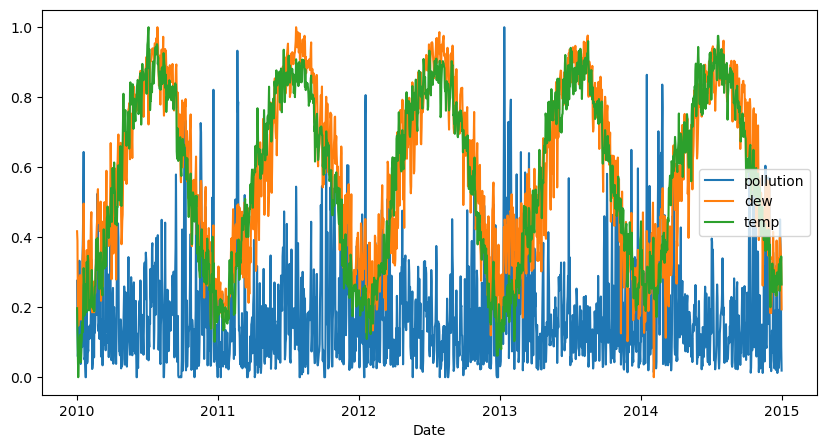

In [61]:
#Plotting different varibles vs the level of pollution
from sklearn.preprocessing import minmax_scale
scaled_price_block_df=pd.DataFrame(minmax_scale(df[['pollution','dew','temp']]), columns=['pollution','dew','temp'], index=df.index)
scaled_price_block_df.plot(figsize=(10,5));

## Making a windowed dataset with pandas

In [62]:
# Set-up dataset hyperparameters
HORIZON=1
WINDOW_SIZE=7

In [63]:
#Make a copy of the Bitcoin historical data with block reward feature
df_windowed=df.copy()

#Add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in WINDOW_SIZE
  df_windowed[f"Pollution+{i+1}"]=df_windowed['pollution'].shift(periods=i+1)
df_windowed.head(10)

,pollution,dew,temp,press,wnd_spd,snow,rain,Pollution+1,Pollution+2,Pollution+3,Pollution+4,Pollution+5,Pollution+6,Pollution+7
Date,,,,,,,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333,145.958333,NaN,NaN,NaN,NaN,NaN
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333,78.833333,145.958333,NaN,NaN,NaN,NaN
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333,31.333333,78.833333,145.958333,NaN,NaN,NaN
2010-01-07,69.000000,-21.250000,-12.500000,1034.083333,10.170000,0.000000,0.0,56.416667,42.458333,31.333333,78.833333,145.958333,NaN,NaN
2010-01-08,176.208333,-17.125000,-11.708333,1028.000000,1.972917,0.000000,0.0,69.000000,56.416667,42.458333,31.333333,78.833333,145.958333,NaN
2010-01-09,88.500000,-16.333333,-9.125000,1029.041667,13.298750,0.000000,0.0,176.208333,69.000000,56.416667,42.458333,31.333333,78.833333,145.958333
2010-01-10,57.250000,-15.958333,-8.750000,1032.500000,17.415833,0.000000,0.0,88.500000,176.208333,69.000000,56.416667,42.458333,31.333333,78.833333


In [64]:
#Create X (windows) and y (horizons) features
X=df_windowed.dropna().drop("pollution",axis=1).astype(np.float32)
y=df_windowed.dropna()["pollution"].astype(np.float32)

#Make train and test sets using indexing
split_size=int(len(X)*0.8)
X_train,y_train=X[:split_size],y[:split_size]
X_test,y_test=X[split_size:],y[split_size:]
len(X_train),len(y_train),len(X_test),len(y_test)

(1454, 1454, 364, 364)

## Model 6 : Dense (multivariate time series)

In [65]:
tf.random.set_seed(42)

#Make multivariate time series model
model_6=tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name='model_6_multivariate')

#Compile
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

#3 Fit the model
model_6.fit(x=X_train,
            y=y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test,y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/12 [=>............................] - ETA: 7s - loss: 72.0892INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 137ms/step - loss: 61.6761 - val_loss: 55.4621
Epoch 2/100
 1/12 [=>............................] - ETA: 0s - loss: 58.3616INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 158ms/step - loss: 54.3140 - val_loss: 52.8996
Epoch 3/100
 1/12 [=>............................] - ETA: 0s - loss: 58.8839INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 117ms/step - loss: 50.4298 - val_loss: 50.4818
Epoch 4/100
 1/12 [=>............................] - ETA: 0s - loss: 51.3396INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 118ms/step - loss: 47.6224 - val_loss: 49.2902
Epoch 5/100
 1/12 [=>............................] - ETA: 0s - loss: 44.4055INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 118ms/step - loss: 46.5777 - val_loss: 47.4604
Epoch 6/100
 1/12 [=>............................] - ETA: 0s - loss: 47.0493INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 153ms/step - loss: 45.4297 - val_loss: 47.0269
Epoch 7/100
 1/12 [=>............................] - ETA: 0s - loss: 48.2434INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 115ms/step - loss: 44.8446 - val_loss: 46.3026
Epoch 8/100
 1/12 [=>............................] - ETA: 0s - loss: 56.5887INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 115ms/step - loss: 44.2093 - val_loss: 45.5793
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 43.7630 - val_loss: 45.6480
Epoch 10/100
 1/12 [=>............................] - ETA: 0s - loss: 41.9605INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 43.7229 - val_loss: 44.8123
Epoch 11/100
12/12 [==============================] - 0s 7ms/step - loss: 43.2551 - val_loss: 44.9613
Epoch 12/100
 1/12 [=>............................] - ETA: 0s - loss: 44.5340INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 153ms/step - loss: 43.0551 - val_loss: 44.6779
Epoch 13/100
 1/12 [=>............................] - ETA: 0s - loss: 41.2663INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 117ms/step - loss: 42.8696 - val_loss: 44.3824
Epoch 14/100
12/12 [==============================] - 0s 7ms/step - loss: 42.7013 - val_loss: 44.8256
Epoch 15/100
 1/12 [=>............................] - ETA: 0s - loss: 37.5831INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 42.8933 - val_loss: 44.0969
Epoch 16/100
 1/12 [=>............................] - ETA: 0s - loss: 42.4064INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 152ms/step - loss: 42.3811 - val_loss: 43.9097
Epoch 17/100
 1/12 [=>............................] - ETA: 0s - loss: 42.6327INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 120ms/step - loss: 42.2526 - val_loss: 43.7995
Epoch 18/100
 1/12 [=>............................] - ETA: 0s - loss: 43.0525INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 42.5001 - val_loss: 43.7233
Epoch 19/100
 1/12 [=>............................] - ETA: 0s - loss: 40.1349INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 42.8757 - val_loss: 43.6702
Epoch 20/100
 1/12 [=>............................] - ETA: 0s - loss: 41.4221INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 158ms/step - loss: 41.9677 - val_loss: 43.5707
Epoch 21/100
 1/12 [=>............................] - ETA: 0s - loss: 38.9179INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 41.6115 - val_loss: 43.4452
Epoch 22/100
 1/12 [=>............................] - ETA: 0s - loss: 39.6801INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 117ms/step - loss: 41.4440 - val_loss: 43.2475
Epoch 23/100
12/12 [==============================] - 0s 7ms/step - loss: 41.5585 - val_loss: 43.2520
Epoch 24/100
 1/12 [=>............................] - ETA: 0s - loss: 41.9206INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 117ms/step - loss: 41.7890 - val_loss: 42.9623
Epoch 25/100
 1/12 [=>............................] - ETA: 0s - loss: 39.1516INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 154ms/step - loss: 41.3892 - val_loss: 42.9441
Epoch 26/100
 1/12 [=>............................] - ETA: 0s - loss: 39.1342INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 118ms/step - loss: 42.2954 - val_loss: 42.8153
Epoch 27/100
12/12 [==============================] - 0s 6ms/step - loss: 42.2651 - val_loss: 43.2284
Epoch 28/100
12/12 [==============================] - 0s 7ms/step - loss: 40.8429 - val_loss: 43.2775
Epoch 29/100
12/12 [==============================] - 0s 7ms/step - loss: 40.6844 - val_loss: 43.0153
Epoch 30/100
 1/12 [=>............................] - ETA: 0s - loss: 42.0018INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 115ms/step - loss: 40.6582 - val_loss: 42.5793
Epoch 31/100
 1/12 [=>............................] - ETA: 0s - loss: 39.1907INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 155ms/step - loss: 40.3319 - val_loss: 42.5141
Epoch 32/100
 1/12 [=>............................] - ETA: 0s - loss: 44.5291INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 127ms/step - loss: 40.4916 - val_loss: 42.4306
Epoch 33/100
 1/12 [=>............................] - ETA: 0s - loss: 34.3954INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 121ms/step - loss: 40.2010 - val_loss: 42.2045
Epoch 34/100
 1/12 [=>............................] - ETA: 0s - loss: 39.6967INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 117ms/step - loss: 40.0640 - val_loss: 41.9863
Epoch 35/100
12/12 [==============================] - 0s 9ms/step - loss: 39.9049 - val_loss: 42.6290
Epoch 36/100
12/12 [==============================] - 0s 7ms/step - loss: 39.7960 - val_loss: 42.0991
Epoch 37/100
12/12 [==============================] - 0s 7ms/step - loss: 39.6240 - val_loss: 42.0046
Epoch 38/100
12/12 [==============================] - 0s 6ms/step - loss: 39.6002 - val_loss: 42.0820
Epoch 39/100
12/12 [==============================] - 0s 6ms/step - loss: 40.1036 - val_loss: 42.0998
Epoch 40/100
 1/12 [=>............................] - ETA: 0s - loss: 42.3872INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 152ms/step - loss: 39.6027 - val_loss: 41.6532
Epoch 41/100
 1/12 [=>............................] - ETA: 0s - loss: 38.3606INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 118ms/step - loss: 39.4809 - val_loss: 41.6333
Epoch 42/100
 1/12 [=>............................] - ETA: 0s - loss: 42.1851INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 119ms/step - loss: 39.3214 - val_loss: 41.5624
Epoch 43/100
12/12 [==============================] - 0s 9ms/step - loss: 39.2132 - val_loss: 41.6855
Epoch 44/100
12/12 [==============================] - 0s 7ms/step - loss: 39.2697 - val_loss: 42.1656
Epoch 45/100
12/12 [==============================] - 0s 8ms/step - loss: 39.4368 - val_loss: 41.6098
Epoch 46/100
12/12 [==============================] - 0s 7ms/step - loss: 39.4061 - val_loss: 41.9306
Epoch 47/100
 1/12 [=>............................] - ETA: 0s - loss: 38.1041INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 39.8383 - val_loss: 41.4440
Epoch 48/100
 1/12 [=>............................] - ETA: 0s - loss: 39.4888INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 155ms/step - loss: 38.7771 - val_loss: 41.4430
Epoch 49/100
 1/12 [=>............................] - ETA: 0s - loss: 41.5751INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 117ms/step - loss: 38.8953 - val_loss: 41.4268
Epoch 50/100
12/12 [==============================] - 0s 7ms/step - loss: 38.6136 - val_loss: 41.7748
Epoch 51/100
12/12 [==============================] - 0s 8ms/step - loss: 38.9712 - val_loss: 41.6179
Epoch 52/100
12/12 [==============================] - 0s 7ms/step - loss: 38.9733 - val_loss: 42.2519
Epoch 53/100
12/12 [==============================] - 0s 7ms/step - loss: 38.6671 - val_loss: 41.4470
Epoch 54/100
 1/12 [=>............................] - ETA: 0s - loss: 38.4040INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 38.5608 - val_loss: 40.6360
Epoch 55/100
12/12 [==============================] - 0s 8ms/step - loss: 38.2472 - val_loss: 40.8912
Epoch 56/100
12/12 [==============================] - 0s 7ms/step - loss: 38.1418 - val_loss: 40.9275
Epoch 57/100
12/12 [==============================] - 0s 7ms/step - loss: 38.1305 - val_loss: 40.9516
Epoch 58/100
12/12 [==============================] - 0s 6ms/step - loss: 38.2920 - val_loss: 41.3648
Epoch 59/100
12/12 [==============================] - 0s 6ms/step - loss: 38.4107 - val_loss: 41.1464
Epoch 60/100
12/12 [==============================] - 0s 7ms/step - loss: 38.5384 - val_loss: 41.1638
Epoch 61/100
12/12 [==============================] - 0s 7ms/step - loss: 38.7844 - val_loss: 41.6990
Epoch 62/100
12/12 [==============================] - 0s 7ms/step - loss: 38.5797 - val_loss: 41.2109
Epoch 63/100
 1/12 [=>............................] - ETA: 0s - loss: 42.0591INFO:tensorflow:

INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 152ms/step - loss: 38.4475 - val_loss: 40.0699
Epoch 64/100
12/12 [==============================] - 0s 7ms/step - loss: 37.6836 - val_loss: 40.8353
Epoch 65/100
12/12 [==============================] - 0s 7ms/step - loss: 37.7771 - val_loss: 40.5303
Epoch 66/100
12/12 [==============================] - 0s 7ms/step - loss: 38.1872 - val_loss: 41.0193
Epoch 67/100
12/12 [==============================] - 0s 7ms/step - loss: 37.8139 - val_loss: 41.6895
Epoch 68/100
12/12 [==============================] - 0s 6ms/step - loss: 38.3264 - val_loss: 40.7762
Epoch 69/100
12/12 [==============================] - 0s 6ms/step - loss: 37.6077 - val_loss: 40.1133
Epoch 70/100
 1/12 [=>............................] - ETA: 0s - loss: 35.0813INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 37.2451 - val_loss: 39.8097
Epoch 71/100
12/12 [==============================] - 0s 8ms/step - loss: 37.3669 - val_loss: 39.9220
Epoch 72/100
12/12 [==============================] - 0s 7ms/step - loss: 37.1528 - val_loss: 40.1921
Epoch 73/100
12/12 [==============================] - 0s 7ms/step - loss: 37.2217 - val_loss: 40.2568
Epoch 74/100
12/12 [==============================] - 0s 7ms/step - loss: 37.2571 - val_loss: 39.8186
Epoch 75/100
 1/12 [=>............................] - ETA: 0s - loss: 40.3595INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 115ms/step - loss: 37.1508 - val_loss: 39.7513
Epoch 76/100
 1/12 [=>............................] - ETA: 0s - loss: 34.9764INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 37.0847 - val_loss: 39.4452
Epoch 77/100
12/12 [==============================] - 0s 7ms/step - loss: 37.0704 - val_loss: 40.1472
Epoch 78/100
 1/12 [=>............................] - ETA: 0s - loss: 35.3357INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 153ms/step - loss: 37.1274 - val_loss: 39.3501
Epoch 79/100
 1/12 [=>............................] - ETA: 0s - loss: 33.3653INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 117ms/step - loss: 37.1355 - val_loss: 39.3288
Epoch 80/100
12/12 [==============================] - 0s 7ms/step - loss: 37.1079 - val_loss: 39.9195
Epoch 81/100
 1/12 [=>............................] - ETA: 0s - loss: 40.0234INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 37.0643 - val_loss: 39.2153
Epoch 82/100
12/12 [==============================] - 0s 7ms/step - loss: 36.8631 - val_loss: 39.9101
Epoch 83/100
12/12 [==============================] - 0s 7ms/step - loss: 36.7914 - val_loss: 39.5229
Epoch 84/100
 1/12 [=>............................] - ETA: 0s - loss: 44.9691INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 115ms/step - loss: 36.6197 - val_loss: 39.1355
Epoch 85/100
 1/12 [=>............................] - ETA: 0s - loss: 31.7538INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 152ms/step - loss: 36.5754 - val_loss: 39.1327
Epoch 86/100
12/12 [==============================] - 0s 7ms/step - loss: 36.4193 - val_loss: 39.3371
Epoch 87/100
 1/12 [=>............................] - ETA: 0s - loss: 35.3889INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 115ms/step - loss: 36.4268 - val_loss: 38.9067
Epoch 88/100
12/12 [==============================] - 0s 9ms/step - loss: 36.5024 - val_loss: 39.0702
Epoch 89/100
12/12 [==============================] - 0s 7ms/step - loss: 36.7120 - val_loss: 39.7748
Epoch 90/100
 1/12 [=>............................] - ETA: 0s - loss: 37.5790INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 114ms/step - loss: 36.8653 - val_loss: 38.9041
Epoch 91/100
12/12 [==============================] - 0s 8ms/step - loss: 37.4462 - val_loss: 39.1918
Epoch 92/100
12/12 [==============================] - 0s 7ms/step - loss: 38.3583 - val_loss: 39.2097
Epoch 93/100
12/12 [==============================] - 0s 8ms/step - loss: 37.4341 - val_loss: 39.0049
Epoch 94/100
12/12 [==============================] - 0s 7ms/step - loss: 36.9084 - val_loss: 39.4398
Epoch 95/100
 1/12 [=>............................] - ETA: 0s - loss: 40.7112INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 2s 169ms/step - loss: 36.5667 - val_loss: 38.8247
Epoch 96/100
 1/12 [=>............................] - ETA: 0s - loss: 38.5922INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 122ms/step - loss: 36.0479 - val_loss: 38.6315
Epoch 97/100
 1/12 [=>............................] - ETA: 0s - loss: 40.2841INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 118ms/step - loss: 35.8950 - val_loss: 38.3436
Epoch 98/100
12/12 [==============================] - 0s 7ms/step - loss: 35.8844 - val_loss: 38.9510
Epoch 99/100
12/12 [==============================] - 0s 7ms/step - loss: 36.0067 - val_loss: 38.5522
Epoch 100/100
 1/12 [=>............................] - ETA: 0s - loss: 36.1893INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_multivariate\assets


12/12 [==============================] - 1s 116ms/step - loss: 35.6304 - val_loss: 38.3201


In [66]:
#Evaluate multivariate model
model_6.evaluate(X_test,y_test)

12/12 [==============================] - 0s 1ms/step - loss: 38.3201


38.320106506347656

In [67]:
#Load in and evaluate best performing model
model_6=tf.keras.models.load_model("model_experiments/model_6_multivariate/")
model_6.evaluate(X_test,y_test)

12/12 [==============================] - 0s 1ms/step - loss: 38.3201


38.320106506347656

In [68]:
#Make predictions with multivariate model
model_6_preds=tf.squeeze(model_6.predict(X_test))
model_6_preds[:2]

12/12 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 88.678604, 140.94223 ], dtype=float32)>

In [69]:
#Evaluate predictions to get eval metrics
model_6_results=evaluate_preds(y_true=y_test,
                               y_pred=model_6_preds)

model_6_results

{'mae': 38.32011,
 'mse': 3022.712,
 'rmse': 54.979195,
 'mape': 64.21242,
 'mase': 0.73575914}

## Model 7: N-BEATS algorithm

### Building and testing the N-BEATS block layer

In [70]:
#Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons:int,
               n_layers:int,
               **kwargs): #the **kwargs argument takes care of all the argument for the parent class(input_shape,trainable,name)
    super(). __init__(**kwargs)
    self.input_size=input_size
    self.theta_size=theta_size
    self.horizon=horizon
    self.n_neurons=n_neurons
    self.n_layers=n_layers

    #Block contains stack of 4 fully connected layers, each has ReLU activation
    self.hidden=[tf.keras.layers.Dense(n_neurons,activation='relu') for i in range(n_layers)]
    #Output of block is a theta layer with linear activation
    self.theta_layer=tf.keras.layers.Dense(theta_size,activation='linear',name='theta')

  def call(self,inputs):
    x=inputs
    for layer in self.hidden:
      x=layer(x)
    theta=self.theta_layer(x)
    #Output the backcast and the forecast from theta
    backcast,forecast=theta[:,:self.input_size] ,theta[:,-self.horizon:]
    return backcast,forecast

## Preparing data for the N-BEATS algorithm using 'tf.data'

In [71]:
HORIZON=1
WINDOW_SIZE=7

In [72]:
#Create N-BEATS data inputs (N-BEATS works with univariate time series)
df.head()

,pollution,dew,temp,press,wnd_spd,snow,rain
Date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


In [73]:
#Make a copy of the Bitcoin historical data with block reward feature
df_nbeats=df.copy()

#Add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in WINDOW_SIZE
  df_nbeats[f"Pollution+{i+1}"]=df_nbeats['pollution'].shift(periods=i+1)
df_nbeats.head(10)

,pollution,dew,temp,press,wnd_spd,snow,rain,Pollution+1,Pollution+2,Pollution+3,Pollution+4,Pollution+5,Pollution+6,Pollution+7
Date,,,,,,,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333,145.958333,NaN,NaN,NaN,NaN,NaN
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333,78.833333,145.958333,NaN,NaN,NaN,NaN
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333,31.333333,78.833333,145.958333,NaN,NaN,NaN
2010-01-07,69.000000,-21.250000,-12.500000,1034.083333,10.170000,0.000000,0.0,56.416667,42.458333,31.333333,78.833333,145.958333,NaN,NaN
2010-01-08,176.208333,-17.125000,-11.708333,1028.000000,1.972917,0.000000,0.0,69.000000,56.416667,42.458333,31.333333,78.833333,145.958333,NaN
2010-01-09,88.500000,-16.333333,-9.125000,1029.041667,13.298750,0.000000,0.0,176.208333,69.000000,56.416667,42.458333,31.333333,78.833333,145.958333
2010-01-10,57.250000,-15.958333,-8.750000,1032.500000,17.415833,0.000000,0.0,88.500000,176.208333,69.000000,56.416667,42.458333,31.333333,78.833333


In [74]:
df.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain'], dtype='object')

In [75]:
# Make features and labels
X=df_nbeats.dropna().drop(['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain','pollution'],axis=1).astype(np.float32)
y=df_nbeats.dropna()["pollution"].astype(np.float32)

#Make train and test sets using indexing
split_size=int(len(X)*0.8)
X_train,y_train=X[:split_size],y[:split_size]
X_test,y_test=X[split_size:],y[split_size:]
len(X_train),len(y_train),len(X_test),len(y_test)

(1454, 1454, 364, 364)

In [76]:
X_train

,Pollution+1,Pollution+2,Pollution+3,Pollution+4,Pollution+5,Pollution+6,Pollution+7
Date,,,,,,,
2010-01-09,176.208328,69.000000,56.416668,42.458332,31.333334,78.833336,145.958328
2010-01-10,88.500000,176.208328,69.000000,56.416668,42.458332,31.333334,78.833336
2010-01-11,57.250000,88.500000,176.208328,69.000000,56.416668,42.458332,31.333334
2010-01-12,20.000000,57.250000,88.500000,176.208328,69.000000,56.416668,42.458332
2010-01-13,20.750000,20.000000,57.250000,88.500000,176.208328,69.000000,56.416668
...,...,...,...,...,...,...,...
2013-12-28,31.916666,14.625000,180.708328,315.916656,149.833328,177.958328,81.708336
2013-12-29,19.708334,31.916666,14.625000,180.708328,315.916656,149.833328,177.958328
2013-12-30,40.208332,19.708334,31.916666,14.625000,180.708328,315.916656,149.833328


In [77]:
#Time to make our dataset performant using tf.data.API
train_features_dataset=tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset=tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset=tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset=tf.data.Dataset.from_tensor_slices(y_test)

#Combine labels and features by zipping together -> (features,labels)
train_dataset=tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
test_dataset=tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))

#Batch and prefetch
BATCH_SIZE=1024
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset,test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [78]:
#Values from N-BEATS paper
N_EPOCHS=500
N_NEURONS=512
N_LAYERS=4
N_STACKS=30
INPUT_SIZE=WINDOW_SIZE*HORIZON
THETA_SIZE=INPUT_SIZE+HORIZON

INPUT_SIZE,THETA_SIZE

(7, 8)

## Building, compiling and fitting the N-BEATS algorithm

1. Set-up an instance of the N-BEATS block layer using 'NBeatsBlock' (this´ll be the initial block used for the network, the rest will be created as part of stacks).
2. Create an input layer for the N-BEATS stack (well´be using the Keras Functional API).
3. Make the initial backcast and forecasts for the model with the layer created in (1).
4. Use for loop to create stacks of block layers.
5. Use the 'NBeatsBlock' class with the for loop in (4) to create blocks which return backcasts and block-level forecasts.
6. Create the double residual stacking using subtract and add layers.
7. Put the model inputs and outputs together using 'tf.keras.model'.
8. Compile the model with MAE loss (the paper uses multiple losses but we´ll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper.
9. Fit the N-BEATS model for 500 epochs and since it´s fitting for so many epochs,we´ll use  a ouple of callbacks:

  *   Early Stopping-because the model will be training for so long, we´ll stop it early if it stops improving).
  *   Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates its weight each time (take smaller steps toward best performance).


In [79]:
%%time

tf.random.set_seed(42)

#1. Set-up an instance of NBeatsBlock
nbeats_block_layer=NBeatsBlock(input_size=INPUT_SIZE,
                               theta_size=THETA_SIZE,
                               horizon=HORIZON,
                               n_neurons=N_NEURONS,
                               n_layers=N_LAYERS,
                               name='Initial_Block')

#2. Create input to stack
stack_input=layers.Input(shape=(INPUT_SIZE),name='stack_input')

#3. Create initial backcast and forecast input(backwards prediction + horizon prediction)
residuals,forecast=nbeats_block_layer(stack_input)

#4. Create stacks of block layers
for i,_ in enumerate(range(N_STACKS-1)) : #first stack is already created in (3)

  #5. Use the NBeatsBlock to calculate the backcast
  backcast,block_forecast=NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f'NBeatsBlock_{i}'
  )(residuals) #pass in he residuals

  #6. Create the double residual stacking
  residuals=layers.subtract([residuals,backcast],name=f"Subtract_{i}")
  forecast=layers.add([forecast,block_forecast],name=f"Add_{i}")

#7. Put the stack model together
model_7=tf.keras.Model(inputs=stack_input,outputs=forecast,name='model_7_NBEATS')

#8. Compile model with MAE loss
model_7.compile(loss='mae',optimizer=tf.keras.optimizers.Adam())

#9 Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=200,restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=100,
                                                            verbose=1)])


Epoch 1/500
2/2 [==============================] - 26s 5s/step - loss: 99.3464 - val_loss: 300.3887 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 2s 835ms/step - loss: 224.1478 - val_loss: 55.6671 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 2s 728ms/step - loss: 56.3006 - val_loss: 59.8628 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 2s 832ms/step - loss: 58.0190 - val_loss: 51.6895 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 2s 938ms/step - loss: 53.2113 - val_loss: 49.1063 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 2s 744ms/step - loss: 49.8650 - val_loss: 50.5583 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 2s 872ms/step - loss: 49.6963 - val_loss: 47.6896 - lr: 0.0010
Epoch 8/500
2/2 [==============================] - 2s 992ms/step - loss: 47.9093 - val_loss: 47.4886 - lr: 0.0010
Epoch 9/500
2/2 [==============================] - 2s 781ms/step - loss: 47.9188 - val_l

2/2 [==============================] - 2s 760ms/step - loss: 35.9160 - val_loss: 49.3585 - lr: 0.0010
Epoch 73/500
2/2 [==============================] - 2s 784ms/step - loss: 35.3708 - val_loss: 49.3581 - lr: 0.0010
Epoch 74/500
2/2 [==============================] - 2s 800ms/step - loss: 34.6604 - val_loss: 48.7822 - lr: 0.0010
Epoch 75/500
2/2 [==============================] - 2s 776ms/step - loss: 33.7583 - val_loss: 50.0867 - lr: 0.0010
Epoch 76/500
2/2 [==============================] - 2s 712ms/step - loss: 33.3234 - val_loss: 48.3961 - lr: 0.0010
Epoch 77/500
2/2 [==============================] - 2s 712ms/step - loss: 33.2874 - val_loss: 49.0645 - lr: 0.0010
Epoch 78/500
2/2 [==============================] - 2s 704ms/step - loss: 32.8681 - val_loss: 49.5147 - lr: 0.0010
Epoch 79/500
2/2 [==============================] - 2s 720ms/step - loss: 32.9640 - val_loss: 52.8399 - lr: 0.0010
Epoch 80/500
2/2 [==============================] - 2s 712ms/step - loss: 37.1107 - val_loss:

2/2 [==============================] - 2s 760ms/step - loss: 20.4344 - val_loss: 52.2804 - lr: 1.0000e-04
Epoch 142/500
2/2 [==============================] - 2s 800ms/step - loss: 20.2475 - val_loss: 52.1107 - lr: 1.0000e-04
Epoch 143/500
2/2 [==============================] - 2s 776ms/step - loss: 20.0095 - val_loss: 51.7267 - lr: 1.0000e-04
Epoch 144/500
2/2 [==============================] - 2s 768ms/step - loss: 19.7260 - val_loss: 51.5447 - lr: 1.0000e-04
Epoch 145/500
2/2 [==============================] - 2s 736ms/step - loss: 19.5405 - val_loss: 51.6635 - lr: 1.0000e-04
Epoch 146/500
2/2 [==============================] - 2s 752ms/step - loss: 19.3923 - val_loss: 51.8708 - lr: 1.0000e-04
Epoch 147/500
2/2 [==============================] - 2s 728ms/step - loss: 19.1822 - val_loss: 51.8684 - lr: 1.0000e-04
Epoch 148/500
2/2 [==============================] - 2s 848ms/step - loss: 19.0234 - val_loss: 51.7548 - lr: 1.0000e-04
Epoch 149/500
2/2 [==============================] - 2

2/2 [==============================] - 2s 807ms/step - loss: 14.3993 - val_loss: 53.2671 - lr: 1.0000e-04
Epoch 210/500
2/2 [==============================] - 2s 744ms/step - loss: 14.6617 - val_loss: 53.2397 - lr: 1.0000e-04
Epoch 211/500
2/2 [==============================] - 2s 808ms/step - loss: 14.6405 - val_loss: 53.5951 - lr: 1.0000e-04
Epoch 212/500
2/2 [==============================] - 2s 760ms/step - loss: 14.5105 - val_loss: 53.3231 - lr: 1.0000e-04
Epoch 213/500
2/2 [==============================] - 2s 760ms/step - loss: 14.0544 - val_loss: 53.1437 - lr: 1.0000e-04
Epoch 214/500
2/2 [==============================] - 2s 840ms/step - loss: 13.9063 - val_loss: 53.1703 - lr: 1.0000e-04
Epoch 215/500
2/2 [==============================] - 2s 736ms/step - loss: 13.6827 - val_loss: 53.1347 - lr: 1.0000e-04
Epoch 216/500
2/2 [==============================] - 2s 800ms/step - loss: 13.6182 - val_loss: 52.9442 - lr: 1.0000e-04
Epoch 217/500
2/2 [==============================] - 2

In [80]:
#Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 104ms/step - loss: 46.2380


46.238033294677734

In [81]:
#Make predictions with N-BEATS model
model_7_preds=make_preds(model_7,test_dataset)
model_7_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 41.83819, 118.25122], dtype=float32)>

In [82]:
#Evaluate N-BEATS model preds
model_7_results=evaluate_preds(y_test,
                               model_7_preds)
model_7_results

{'mae': 46.238033,
 'mse': 4354.465,
 'rmse': 65.98837,
 'mape': 82.91604,
 'mase': 0.8877859}

### Plotting the N-BEATS architecture we´ve created

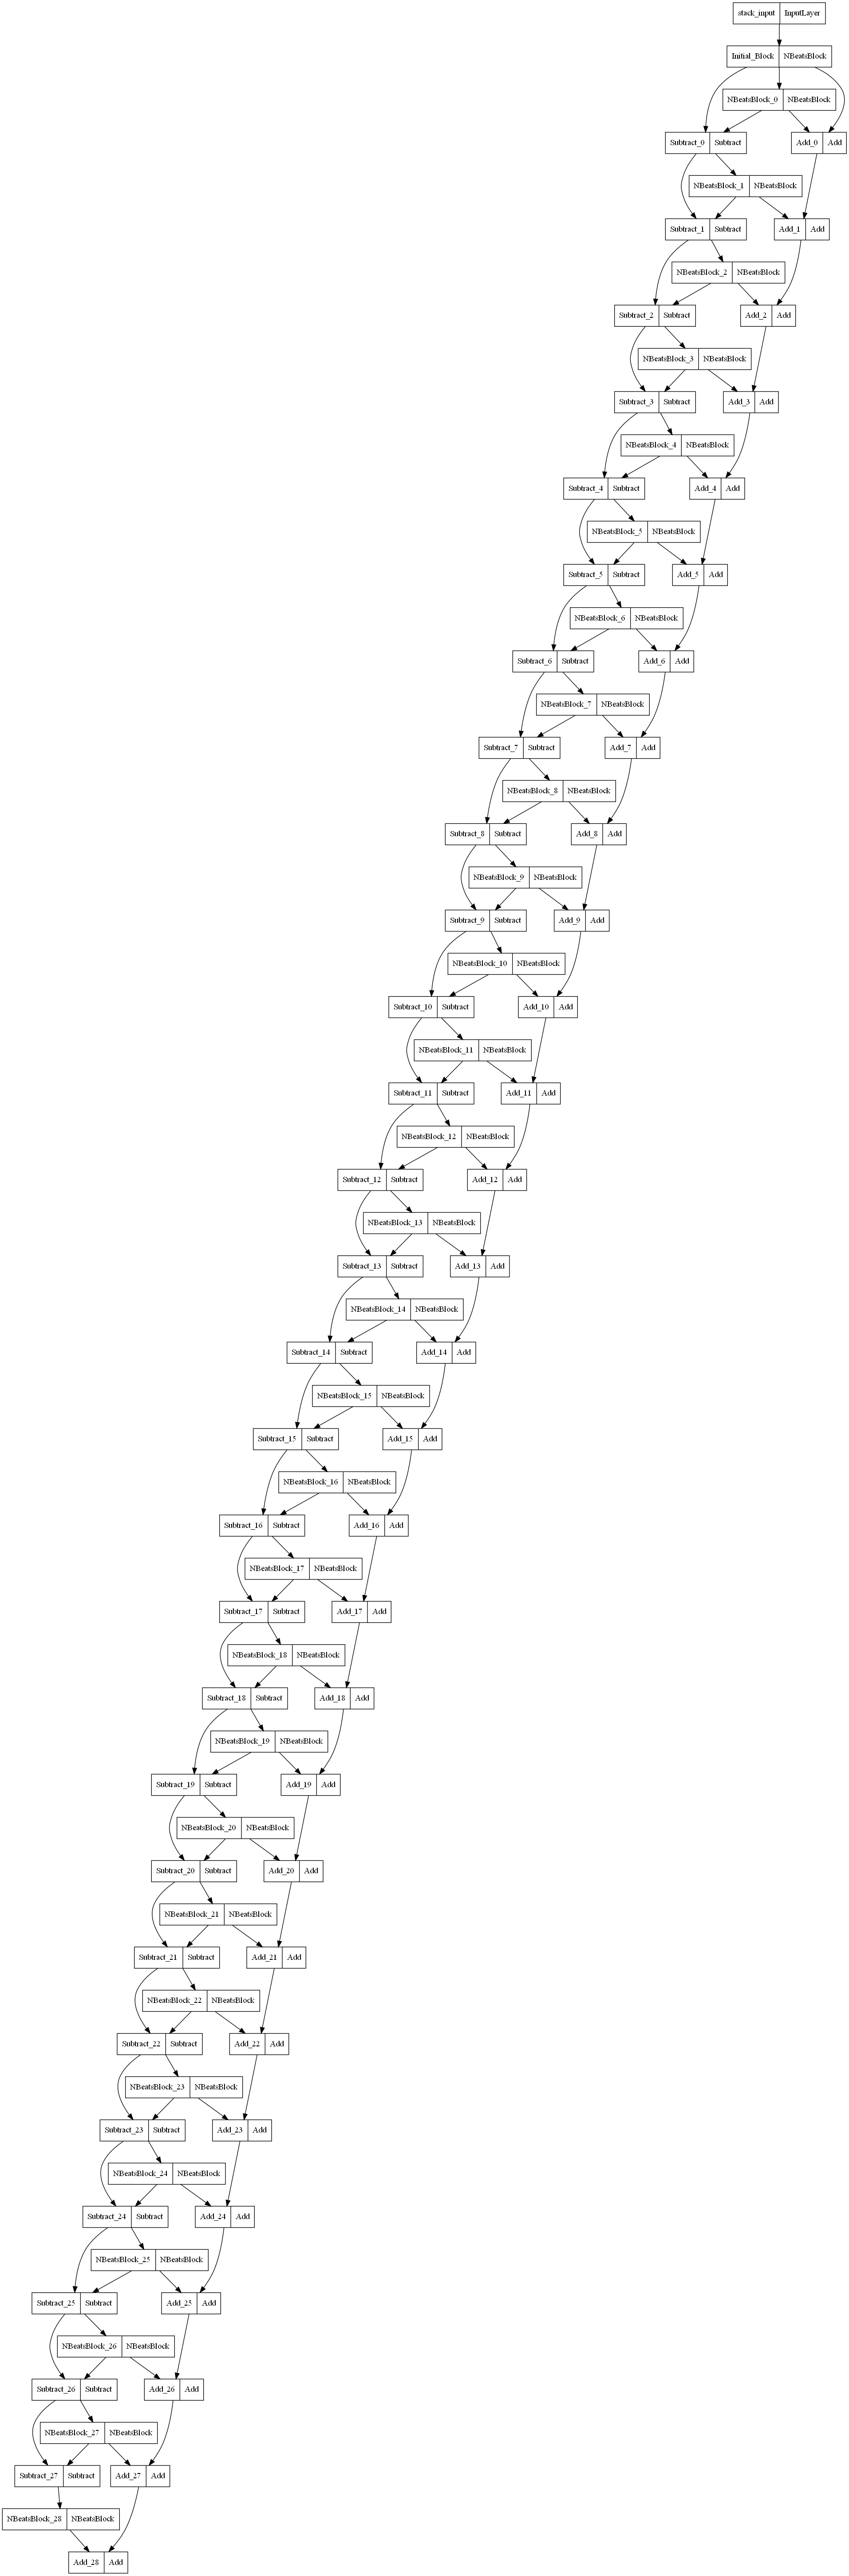

In [83]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

In [84]:
HORIZON=1
WINDOW_SIZE=7

### Constructing and fitting and ensemble of models (using different loss functions)

In [85]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=['mae','mse','mape']):
  """
  Returns a list of num_iter_models each trained on MAE,MSE and MAPE loss

  For example,if num_iter=10, a list of 30 trained models will be returned:
  10 * len (['mae','mse','mape']).
  """

  #Make empty list for trained ensemble models
  ensemble_models=[]

  #Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing:{loss_function} epochs,model number:{i}")

      #Construct a simple model (similar to model_1)
      model=tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals
          layers.Dense(128,kernel_initializer='he_normal', activation='relu'),
          layers.Dense(128,kernel_initializer='he_normal',activation='relu'),
          layers.Dense(HORIZON)
      ])

      #Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae','mse'])

      #Fit the model
      model.fit(train_dataset,
              epochs=num_epochs,
              verbose=0,
              validation_data=test_data,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=200,
                                                          restore_best_weights=True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor='vall_loss',
                                                        patience=100,
                                                        verbose=1)])
      #Append fitted model to list of ensemble model
      ensemble_models.append(model)

  return ensemble_models

In [86]:
%%time
#Get list of trained ensemble models
ensemble_models=get_ensemble_models(num_iter=5,
                                   num_epochs=100)

Optimizing model by reducing:mae epochs,model number:0


Optimizing model by reducing:mse epochs,model number:0


Optimizing model by reducing:mape epochs,model number:0


Optimizing model by reducing:mae epochs,model number:1


Optimizing model by reducing:mse epochs,model number:1


Optimizing model by reducing:mape epochs,model number:1


Optimizing model by reducing:mae epochs,model number:2


Optimizing model by reducing:mse epochs,model number:2


Optimizing model by reducing:mape epochs,model number:2


Optimizing model by reducing:mae epochs,model number:3


Optimizing model by reducing:mse epochs,model number:3


Optimizing model by reducing:mape epochs,model number:3


Optimizing model by reducing:mae epochs,model number:4


Optimizing model by reducing:mse epochs,model number:4


Optimizing model by reducing:mape epochs,model number:4


CPU times: total: 20min 39s
Wall time: 1min 44s


## Make predictions with our ensemble model

In [87]:
#Create a function which uses a list of trained models to make and return a
#of predictions

def make_ensemble_preds(ensemble_models,data):
  ensemble_preds=[]
  for model in ensemble_models:
    preds=model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [89]:
#Create a list of ensemble predictions

ensemble_preds=make_ensemble_preds(ensemble_models=ensemble_models,
                                   data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 105ms/step


<tf.Tensor: shape=(15, 364), dtype=float32, numpy=
array([[ 37.02389  ,  87.95664  ,  25.466015 , ..., 136.44257  ,
        119.378746 ,  47.713287 ],
       [ 36.958553 , 129.10756  ,  42.21801  , ..., 177.17519  ,
         98.96936  ,  55.552914 ],
       [  3.287507 ,  41.89787  , -21.683428 , ..., -10.506755 ,
        -22.952822 , -26.315622 ],
       ...,
       [ 33.13342  , 113.73084  ,  34.88622  , ..., 109.584145 ,
        122.06913  ,  38.070827 ],
       [ 38.63258  , 112.82451  ,  39.918655 , ..., 137.51631  ,
        140.51915  ,  62.80374  ],
       [ -2.7450264,  24.247955 ,  -6.545125 , ...,  72.28695  ,
         32.976963 , -15.045915 ]], dtype=float32)>

In [346]:
#Evaluate ensemble model predictions (
ensemble_results=evaluate_preds(y_true=y_test,
                                y_pred=ensemble_preds)
ensemble_results

{'mae': 62.85686,
 'mse': 7858.7593,
 'rmse': 85.251724,
 'mape': 96.2101,
 'mase': 1.2068729}

In [348]:
#Evaluate ensemble model predictions (mean)
ensemble_mean=tf.reduce_mean(ensemble_preds,axis=0)

ensemble_results=evaluate_preds(y_true=y_test,
                                y_pred=ensemble_mean)
ensemble_results

{'mae': 52.770367,
 'mse': 5532.0547,
 'rmse': 74.377785,
 'mape': 72.73953,
 'mase': 1.013209}

In [93]:
#Evaluate ensemble model predictions (median)

ensemble_median=np.median(ensemble_preds,axis=0)

ensemble_results=evaluate_preds(y_true=y_test,
                                y_pred=ensemble_median)
ensemble_results

{'mae': 48.288372,
 'mse': 4608.187,
 'rmse': 67.88363,
 'mape': 85.03905,
 'mase': 0.9271531}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models (we´ve got this thanks to our ensemble models).

2. Measure the standard deviation of the predictions.
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observation fall within standard deviations of the mean).

4. To get the predictions interval upper and lower bound,add and subtract the value obtained in (3) to the mean/median of the predictions made in (1).
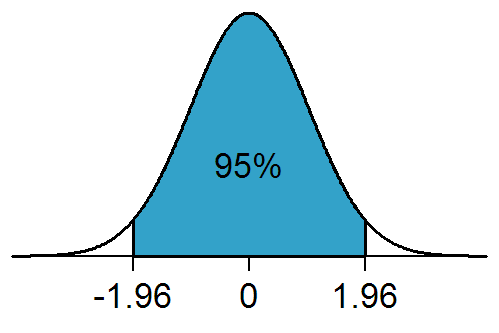

In [94]:
# Find upper and lower bounds of ensemble predictions

def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std=tf.math.reduce_std(preds,axis=0)

  #3. Multiply the standard deviation by 1.96
  interval=1.96*std

  #4. Get the prediction interval upper and lower bounds
  preds_mean=tf.reduce_mean(preds,axis=0)
  lower,upper=preds_mean-interval,preds_mean+interval

  return lower,upper

In [95]:
# Get the upper and lower bounds of the 95% precent prediction interval
lower,upper=get_upper_lower(preds=ensemble_preds)

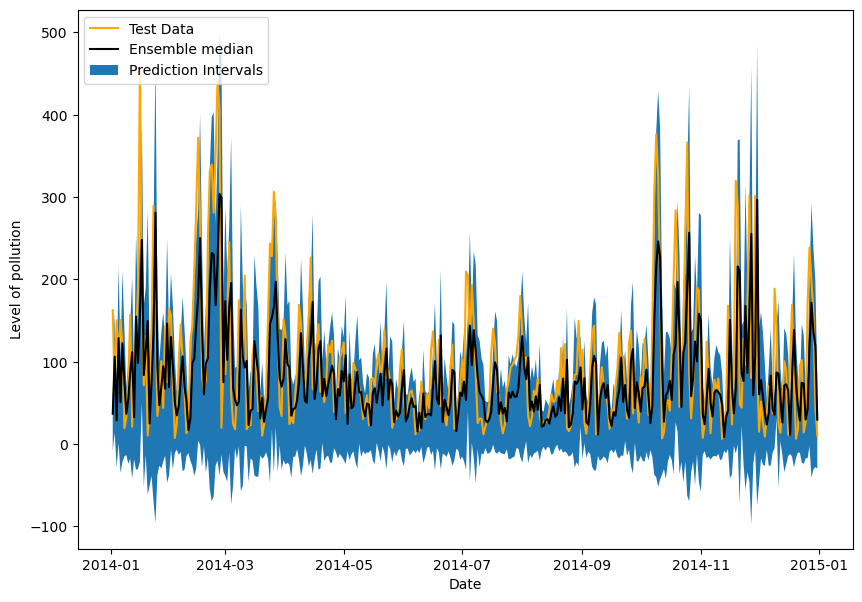

In [111]:
# Get the median/mean values of our ensemble preds
ensembe_median=np.median(ensemble_preds,axis=0)

#Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=0
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:],y_test[offset:],'orange',label='Test Data');
plt.plot(X_test.index[offset:],ensembe_median[offset:],'k-',label='Ensemble median');
plt.xlabel('Date');
plt.ylabel("Level of pollution");
# To plot the upper and lower bound, we´ll use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label='Prediction Intervals');
plt.legend(loc='upper left' , fontsize=10);


## Evaluating the performing of the models

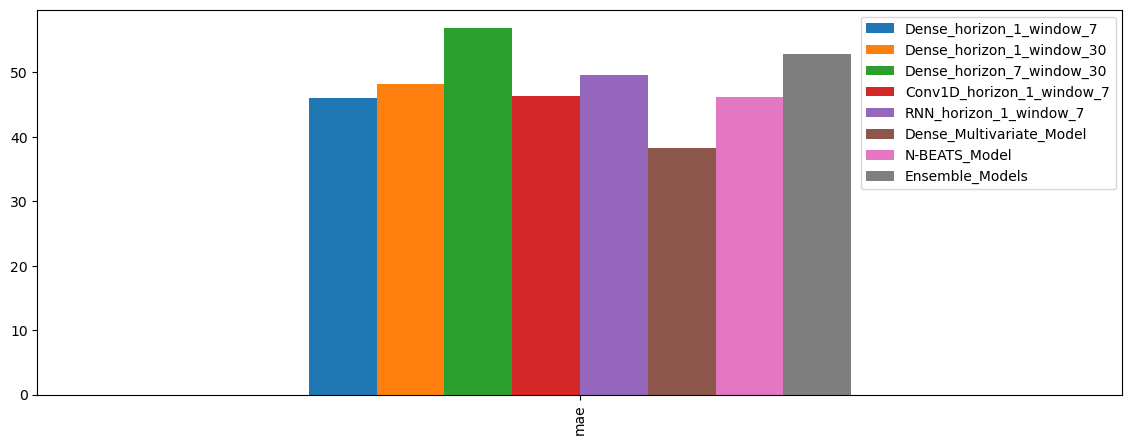

In [352]:
import pandas as pd
pd.DataFrame({'Dense_horizon_1_window_7':model_1_results['mae'],
              'Dense_horizon_1_window_30':model_2_results['mae'],
              'Dense_horizon_7_window_30':model_3_results['mae'],
             'Conv1D_horizon_1_window_7':model_4_results['mae'],
             'RNN_horizon_1_window_7':model_5_results['mae'],
             'Dense_Multivariate_Model':model_6_results['mae'],
             'N-BEATS_Model':model_7_results['mae'],
             'Ensemble_Models':ensemble_results['mae']},index=['mae']).plot(figsize=(14,5),kind='bar');

## Model 9 : Train a model on the full historical data to make predictions into the future

In [109]:
HORIZON=1
WINDOW_SIZE=7

In [112]:
df_windowed.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,Pollution+1,Pollution+2,Pollution+3,Pollution+4,Pollution+5,Pollution+6,Pollution+7
Date,,,,,,,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333,145.958333,NaN,NaN,NaN,NaN,NaN
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333,78.833333,145.958333,NaN,NaN,NaN,NaN
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333,31.333333,78.833333,145.958333,NaN,NaN,NaN


In [115]:
# Train model on entire data to make predictions for the next day
X_all=df_windowed.dropna().drop(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain'],axis=1).to_numpy()

#Get labels
y_all=df_windowed.dropna()['pollution'].to_numpy()

len(X_all) , len(y_all)

(1818, 1818)

In [116]:
# Turn data into efficient running tensors

features_dataset_all=tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all=tf.data.Dataset.from_tensor_slices(y_all)


#Combine features and labels
dataset_all=tf.data.Dataset.zip((features_dataset_all,labels_dataset_all))


#Batch and prefetch for optimal performance
BATCH_SIZE=1024
dataset_all=dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [117]:
tf.random.set_seed(42)

# Create model (nice and simple,just to set)
model_9=tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name='model_9_future_model')

#Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

#Fit model on all of the data to make future podcasts
model_9.fit(dataset_all,
                epochs=100,
                verbose=1
               )

Epoch 1/100
2/2 [==============================] - 1s 46ms/step - loss: 75.4706
Epoch 2/100
2/2 [==============================] - 0s 28ms/step - loss: 63.0379
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 59.5286
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 59.8148
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 59.0051
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 56.5155
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 53.8801
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 52.1578
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 51.4635
Epoch 10/100
2/2 [==============================] - 0s 10ms/step - loss: 50.9530
Epoch 11/100
2/2 [==============================] - 0s 9ms/step - loss: 49.9185
Epoch 12/100
2/2 [==============================] - 0s 6ms/step - loss: 48.8268
Epoch 13/100
2/2 [============================

### Make predictions into future

In [306]:
# How many timesteps to predict into the future:
INTO_FUTURE=14

In [307]:
# Create a function to make predictions into the future
def make_future_forecasts(values,model,into_future,window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into future steps after values ends

  Return future forecasts as a list of floats
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast=[]
  last_window=values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which
  # gets predicted on each
  for _ in range(into_future):
    # Predict on the last window then append it again, again, (our model will eventually start to make forecasts on its own forecast)
    future_pred=model.predict(tf.expand_dims(last_window,axis=0),verbose=0)
    print(f"Predict on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()} \n")

    #Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    #Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window=np.append(last_window,future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [308]:
# Make forecasts into te future
future_forecast=make_future_forecasts(values=y_all,
                                      model=model_9,
                                      into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predict on:
 [ 27.         170.25       238.66666667 197.375      159.
  46.08333333  10.04166667] -> Prediction: 18.468713760375977 

Predict on:
 [170.25       238.66666667 197.375      159.          46.08333333
  10.04166667  18.46871376] -> Prediction: 99.90463256835938 

Predict on:
 [238.66666667 197.375      159.          46.08333333  10.04166667
  18.46871376  99.90463257] -> Prediction: 203.32086181640625 

Predict on:
 [197.375      159.          46.08333333  10.04166667  18.46871376
  99.90463257 203.32086182] -> Prediction: 150.0465850830078 

Predict on:
 [159.          46.08333333  10.04166667  18.46871376  99.90463257
 203.32086182 150.04658508] -> Prediction: 147.0309295654297 

Predict on:
 [ 46.08333333  10.04166667  18.46871376  99.90463257 203.32086182
 150.04658508 147.03092957] -> Prediction: 54.92169952392578 

Predict on:
 [ 10.04166667  18.46871376  99.90463257 203.32086182 150.04658508
 147.03092957  54.92169952] -> Prediction: 52.528629302978516 

Predict on:

### Plot future forecast

In [311]:
def get_future_dates(start_date,into_future,offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date + into_future
  """
  start_date=start_date +np.timedelta64(offset,"D") # specify start date, "D" stands for day
  end_date=start_date+np.timedelta64(into_future,"D") #specify end date

  return np.arange(start_date,end_date)  #return a date range between start and end date

In [312]:
df7=df.copy()
import matplotlib.dates as mpl_dates
df7.reset_index(inplace=True)
df7['Date']=df7['Date'].apply(mpl_dates.date2num)

In [313]:
#Last timestep of timesteps(currently in np.datetime64 format)
last_timestep=df7["Date"].iloc[-1].astype(int)
last_timestep

16435

In [314]:
#Get next two weeks of timesteps
next_time_steps=get_future_dates(start_date=last_timestep,
                                 into_future=INTO_FUTURE)
next_time_steps

array([16436, 16437, 16438, 16439, 16440, 16441, 16442, 16443, 16444,
       16445, 16446, 16447, 16448, 16449], dtype='timedelta64[D]')

In [316]:
# Insert last timestep/final_price into next time steps and future forecasts so the plot doesn´t look messy

next_time_steps=np.insert(next_time_steps,0,last_timestep)
future_forecast=np.insert(future_forecast,0,pollution[-1])

next_time_steps,future_forecast

(array([16435, 16436, 16437, 16438, 16439, 16440, 16441, 16442, 16443,
        16444, 16445, 16446, 16447, 16448, 16449], dtype='timedelta64[D]'),
 array([ 10.041667,  18.468714,  99.90463 , 203.32086 , 150.04659 ,
        147.03093 ,  54.9217  ,  52.52863 ,  18.514233,  47.583847,
        176.5682  , 122.38406 , 145.3238  ,  57.02586 ,  95.58594 ],
       dtype=float32))

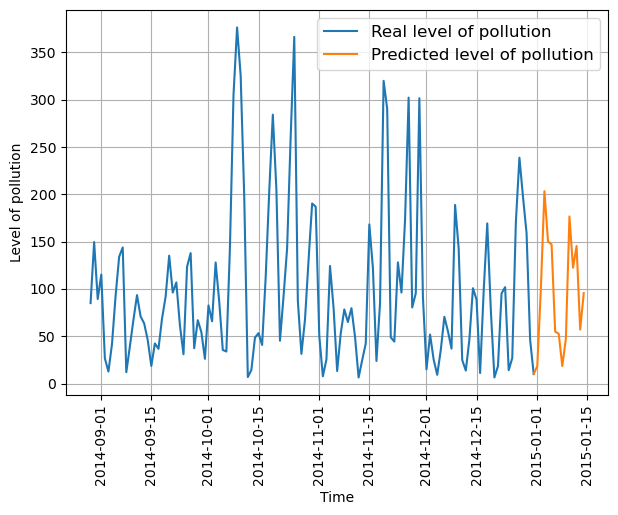

In [354]:
# Plot future prices predictions of level of pollution
plt.figure(figsize=(7,5));
plt.plot(df_windowed.index[1700:],df_windowed.pollution[1700:],'-',label='Real level of pollution');
plt.plot(next_time_steps,future_forecast,'-',label='Predicted level of pollution');
plt.xlabel("Time");
plt.ylabel("Level of pollution");
plt.xticks(rotation ='vertical')
plt.legend(fontsize=12); 
plt.grid(True);